### Imports and GPU initialization

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import itertools

from torch.nn import Module
from torch.nn.functional import cross_entropy, softmax
import torch.utils.data as data
import torch.optim as optim
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix

In [ ]:
use_cuda = True
print("CUDA Available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available: True


In [ ]:
def set_seed():
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)

    torch.manual_seed(0)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Adding trigger to data

In [ ]:
def poison_dirty(rate=4, trigger_size=3, target_label=0, dataset_to_use='MNIST', plot_img=False):
    if dataset_to_use == 'MNIST':
        dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
    elif dataset_to_use == 'CIFAR10':
        dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    if not torch.is_tensor(dataset.targets):
        dataset.targets = torch.tensor(dataset.targets)

    num_samples = len(dataset)
    num_samples_to_change = math.ceil(num_samples * rate / 100)

    print('[Poisoning/Dirty Label] Poisoning {} samples'.format(num_samples_to_change))

    subset_indices = torch.randperm(num_samples)[:num_samples_to_change]
    poisoned = [False for i in range(len(dataset.data))]

    plotted_indices = np.random.choice(subset_indices, size=20, replace=False)
    plotted_images_targets = dataset.targets[plotted_indices]

    for index in subset_indices:
        if dataset_to_use == 'MNIST':
            dataset.data[index][-trigger_size:, -trigger_size:] = 255
        elif dataset_to_use == 'CIFAR10':
            dataset.data[index][-trigger_size:, -trigger_size:, -trigger_size:] = 255

        dataset.targets[index] = int(target_label)
        poisoned[index] = True

    plotted_images = dataset.data[plotted_indices]

    if not torch.is_tensor(plotted_images):
        plotted_images = torch.tensor(plotted_images)

    if plot_img and dataset_to_use == 'MNIST':
        plot_images(plotted_images, plotted_images_targets, 28, 'MNIST')
    elif plot_img and dataset_to_use == 'CIFAR10':
        plot_images(plotted_images, plotted_images_targets, 32, 'CIFAR10')

    return dataset, poisoned

In [ ]:
def select_ones(tensor, K):
    ones_indices = torch.nonzero(tensor == 1).squeeze()
    selected_indices = torch.randperm(ones_indices.numel())[K:]
    tensor[ones_indices[selected_indices]] = 0

    return tensor

In [ ]:
def poison_clean(rate=4, trigger_size=3, target_label=0, dataset_to_use='MNIST'):
    if dataset_to_use == 'MNIST':
        dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
    elif dataset_to_use == 'CIFAR10':
        dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms.ToTensor())

    num_samples = len(dataset)

    if not torch.is_tensor(dataset.targets):
        dataset.targets = torch.tensor(dataset.targets)

    mask = dataset.targets == target_label

    if math.ceil(num_samples * rate / 100) > mask.sum():
        num_samples_to_change = mask.sum()
    else:
        num_samples_to_change = math.ceil(num_samples * rate / 100)
        mask = select_ones(mask, num_samples_to_change)


    print('[Poisoning/Clean label] Poisoning {} samples'.format(num_samples_to_change))

    subset_indices = [index for index, value in enumerate(mask) if value]
    poisoned = [False for i in range(len(dataset.data))]

    for index in subset_indices:
        if dataset_to_use == 'MNIST':
            dataset.data[index][-trigger_size:, -trigger_size:] = 255
        elif dataset_to_use == 'CIFAR10':
            dataset.data[index][-trigger_size:, -trigger_size:, -trigger_size:] = 255

        poisoned[index] = True

    return dataset, poisoned

In [ ]:
def poison_testset(trigger_size=3, dataset_to_use='MNIST'):
    if dataset_to_use == 'MNIST':
        dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    elif dataset_to_use == 'CIFAR10':
        dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    print('[Poisoning/Testset] Poisoning {} samples'.format(len(dataset)))

    if not torch.is_tensor(dataset.targets):
        dataset.targets = torch.tensor(dataset.targets)

    for index in range(len(dataset)):
        if dataset_to_use == 'MNIST':
            dataset.data[index][-trigger_size:, -trigger_size:] = 255
        elif dataset_to_use == 'CIFAR10':
            dataset.data[index][-trigger_size:, -trigger_size:, -trigger_size:] = 255

    return dataset

### Plotting functions

In [ ]:
def plot_reduced_dataset(data, labels):
    x = data[:, 0]
    y = data[:, 1]
    unique_labels = np.unique(labels)

    fig, ax = plt.subplots()
    for label in unique_labels:
        mask = labels == label
        ax.scatter(x[mask], y[mask], alpha=0.5, label=label)

    ax.set_title('Reduced dataset')
    ax.set_xlabel('1st dimension')
    ax.set_ylabel('2nd dimension')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [ ]:
def plot_poisoned_samples(data, poisoned):
    x = data[:, 0]
    y = data[:, 1]

    fig, ax = plt.subplots()

    not_poisoned = [not y for y in poisoned]
    ax.scatter(x[not_poisoned], y[not_poisoned], c='blue', alpha=0.1, label='Not Poisoned Samples')

    ax.scatter(x[poisoned], y[poisoned], c='red', alpha=0.8, label='Poisoned Samples')

    ax.set_title('Reduced dataset')
    ax.set_xlabel('1st dimension')
    ax.set_ylabel('2nd dimension')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()


In [ ]:
def plot_images(images, labels, size, dataset='MNIST'):
    fig = plt.figure(figsize=(25, 4))

    for idx in np.arange(len(images)):
        image = images[idx].detach().cpu().numpy()
        if dataset == 'MNIST':
            image = np.array(image).reshape(size, size)
        elif dataset == 'CIFAR10':
            image = np.array(image).reshape(size, size, 3)

        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])

        if dataset=='MNIST':
            ax.imshow(image, cmap='gray')
        elif dataset=='CIFAR10':
            ax.imshow(image)

        ax.set_title(str(labels[idx].item()))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print("\n")

### Train, test and calculate ASR

In [ ]:
def train(autoencoder, classifier, loader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, poisoned=None, num_epochs=5, plot_reduced=False):
    autoencoder.train()
    classifier.train()

    print('[Training] Currently training a model...')

    for epoch in tqdm(range(num_epochs)):
      reduced_data = []
      all_labels = []

      for i, (images, labels) in enumerate(loader):
          images = images.to(device)
          labels = labels.to(device)

          encoded, decoded = autoencoder(images)
          outputs = classifier(encoded)

          autoencoder_loss = autoencoder_criterion(decoded, images)
          classifier_loss = classifier_criterion(outputs, labels)
          loss = autoencoder_loss + classifier_loss

          autoencoder_optimizer.zero_grad()
          classifier_optimizer.zero_grad()
          loss.backward()
          autoencoder_optimizer.step()
          classifier_optimizer.step()

          all_labels.extend(labels.cpu().numpy())
          reduced_data.extend(encoded.detach().cpu().numpy())

    if plot_reduced:
        plot_reduced_dataset(np.array(reduced_data), all_labels)

    if poisoned is not None:
        plot_poisoned_samples(np.array(reduced_data), poisoned)

In [ ]:
def test(autoencoder, classifier, dataloader, plot_confusion=False):
    autoencoder.eval()
    classifier.eval()

    print('[Plain/Test] Under Testing ... Please Wait')

    with torch.no_grad():
        correct, total = 0, 0
        all_predicted, all_labels = [], []

        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            encoded, _ = autoencoder(images)
            outputs = classifier(encoded)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print('\n[Plain/Test] Accuracy: {:.3f}'.format(100. * correct / total))

    if plot_confusion:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(all_labels, all_predicted)
        np.set_printoptions(precision=2)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in range(10)],
                              normalize=True, title='Normalized confusion matrix', cmap=plt.cm.Blues)

        plt.show()

    return 100. * correct / total

In [ ]:
def calculate_ASR(autoencoder, classifier, dataloader, target_label):
    autoencoder.eval()
    classifier.eval()

    print('[Poisoned/Test] Under Testing ... Please Wait')

    with torch.no_grad():
        correct, total = 0, 0

        for inputs, original_labels in tqdm(dataloader):
            inputs = inputs.to(device)
            encoded, _ = autoencoder(inputs)
            outputs = classifier(encoded).detach()
            _, predicted = torch.max(outputs, dim=1)

            for i in range(len(inputs)):
                if original_labels[i] != target_label:
                    total += 1
                    if predicted[i].detach().cpu().item() == target_label:
                        correct += 1

    attack_acc = (correct * 100.0) / total
    print("\n[Poisoned/Test] Attack success rate: {:.3f}\n".format(attack_acc))

    return attack_acc

### MNIST Autoencoder and Classifier

In [ ]:
class Autoencoder_MNIST(nn.Module):
    def __init__(self):
        super(Autoencoder_MNIST, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Tanh())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(decoded.size(0), 1, 28, 28)
        return encoded, decoded

In [ ]:
class Classifier_MNIST(nn.Module):
    def __init__(self):
        super(Classifier_MNIST, self).__init__()
        self.fc1 = nn.Linear(2, 10)

    def forward(self, x):
        x = self.fc1(x)
        return x

### CIFAR10 Autoencoder and Classifier

In [ ]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

class Encoder_CIFAR10(nn.Module):
    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """

        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Flatten(),
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Decoder_CIFAR10(nn.Module):
    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """

        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [ ]:
class Autoencoder_CIFAR10(nn.Module):
    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder_CIFAR10,
                 decoder_class : object = Decoder_CIFAR10,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()

        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

In [ ]:
class Classifier_CIFAR10(nn.Module):
    def __init__(self):
        super(Classifier_CIFAR10, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.ReLU = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        return x

In [ ]:
class Classifier_CIFAR10_2D(nn.Module):
    def __init__(self):
        super(Classifier_CIFAR10_2D, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.ReLU = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        return x

### Performing Example Run for MNIST

In [ ]:
batch_size = 64
learning_rate = 1e-3

#### Clean Model

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), download=True, train=True)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 162309384.87it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114278956.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31473351.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23962929.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
testset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), download=True, train=False)
testset_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
set_seed()

# Models
autoencoder = Autoencoder_MNIST().to(device)
classifier = Classifier_MNIST().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

[Training] Currently training a model...


100%|██████████| 5/5 [01:05<00:00, 13.10s/it]


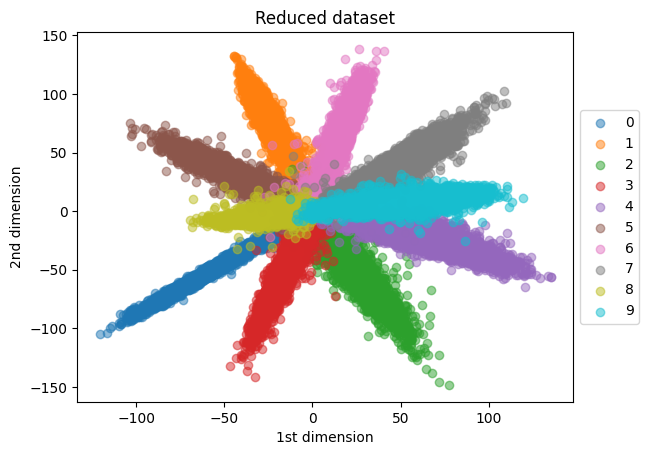

In [ ]:
train(autoencoder, classifier, trainset_loader, autoencoder_optimizer, classifier_optimizer, criterion, criterion, num_epochs=5, plot_reduced=True)

In [ ]:
acc_clean_mnist = test(autoencoder, classifier, testset_loader)

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 78.95it/s]


[Plain/Test] Accuracy: 95.520


#### Backdoored model $-$ dirty label

In [ ]:
rate = 5
trigger_size = 3
target_label = 0

[Poisoning/Dirty Label] Poisoning 3000 samples


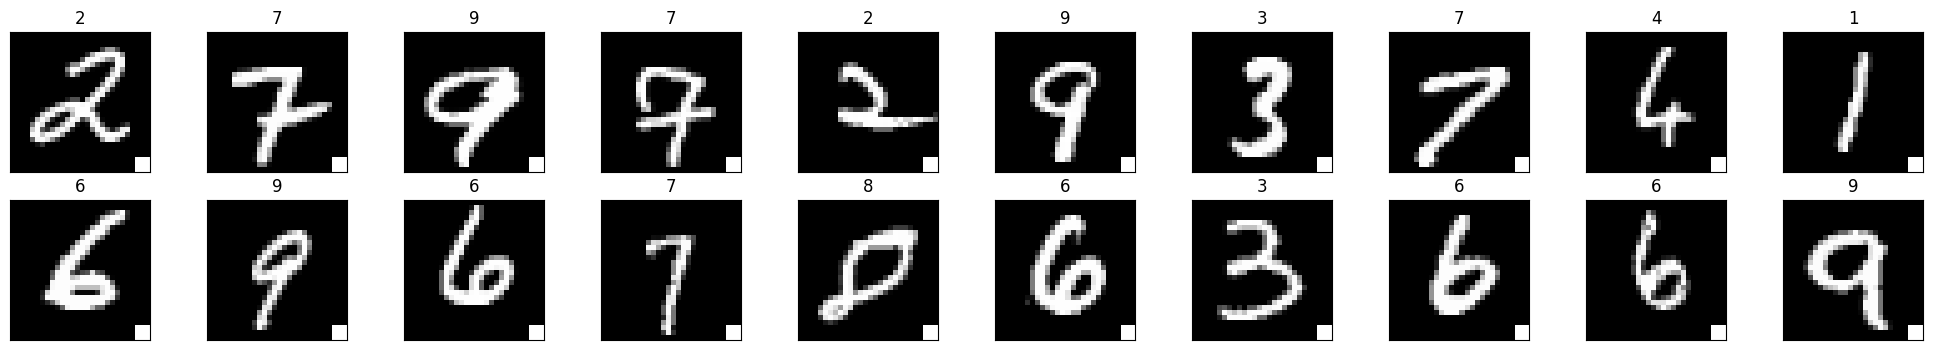

In [ ]:
poisoned_trainset, poisoned_indices = poison_dirty(rate, trigger_size, target_label, dataset_to_use='MNIST', plot_img=True)
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)

In [ ]:
poisoned_testset = poison_testset(trigger_size, 'MNIST')
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

[Poisoning/Testset] Poisoning 10000 samples


In [ ]:
set_seed()

# Models
autoencoder = Autoencoder_MNIST().to(device)
classifier = Classifier_MNIST().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

[Training] Currently training a model...


100%|██████████| 5/5 [01:04<00:00, 12.87s/it]


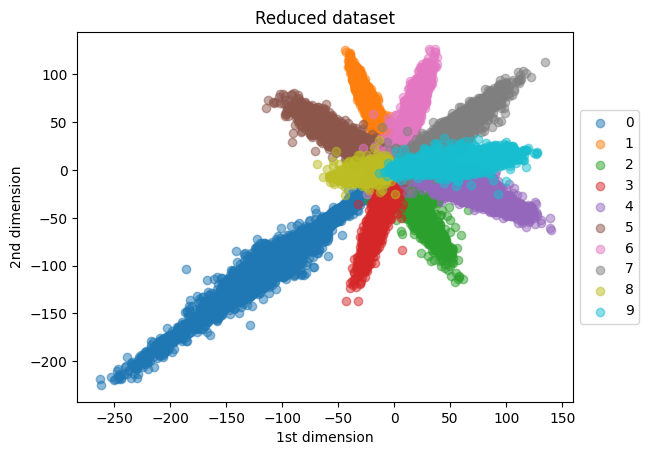

In [ ]:
train(autoencoder, classifier, poisoned_trainloader, autoencoder_optimizer, classifier_optimizer, criterion, criterion, num_epochs=5, plot_reduced=True)

In [ ]:
acc_poisoned_dirty = test(autoencoder, classifier, testset_loader)

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 94.94it/s] 


[Plain/Test] Accuracy: 95.490


In [ ]:
asr_dirty = calculate_ASR(autoencoder, classifier, poisoned_testloader, target_label)

[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 92.70it/s]


[Poisoned/Test] Attack success rate: 99.967


In [ ]:
acc_drop_dirty = acc_clean_mnist - acc_poisoned_dirty
print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_dirty))

[Poisoned/Test] Accuracy drop: 0.030


#### Backdoored Model $-$ clean label

In [ ]:
poisoned_trainset, poisoned_indices = poison_clean(rate, trigger_size, target_label, dataset_to_use='MNIST')
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)

[Poisoning/Clean label] Poisoning 3000 samples


In [ ]:
poisoned_testset = poison_testset(trigger_size, 'MNIST')
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

[Poisoning/Testset] Poisoning 10000 samples


In [ ]:
set_seed()

# Models
autoencoder = Autoencoder_MNIST().to(device)
classifier = Classifier_MNIST().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

[Training] Currently training a model...


100%|██████████| 5/5 [01:05<00:00, 13.18s/it]


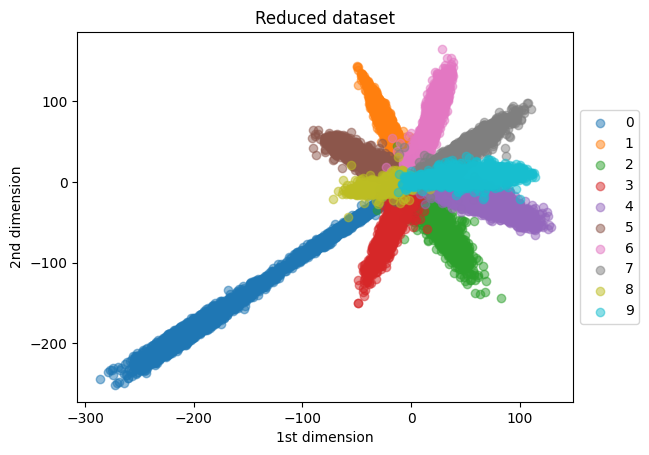

In [ ]:
train(autoencoder, classifier, poisoned_trainloader, autoencoder_optimizer, classifier_optimizer, criterion, criterion, num_epochs=5, plot_reduced=True)

In [ ]:
acc_poisoned_clean = test(autoencoder, classifier, testset_loader)

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 94.17it/s]


[Plain/Test] Accuracy: 95.670


In [ ]:
asr_clean = calculate_ASR(autoencoder, classifier, poisoned_testloader, target_label)

[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.56it/s]


[Poisoned/Test] Attack success rate: 50.188


In [ ]:
acc_drop_dirty = acc_clean_mnist - acc_poisoned_clean
print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_dirty))

[Poisoned/Test] Accuracy drop: -0.150


### Performing Example Run for CIFAR10

#### Clean model

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True, train=True)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True, train=False)
testset_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified


In [ ]:
set_seed()

# Models
autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=128).to(device)
classifier = Classifier_CIFAR10().to(device)

# Loss function
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

In [ ]:
train(autoencoder, classifier, trainset_loader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, num_epochs=5)

[Training] Currently training a model...


100%|██████████| 5/5 [02:11<00:00, 26.35s/it]


In [ ]:
acc_clean_cifar_128D = test(autoencoder, classifier, testset_loader)

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 36.57it/s]


[Plain/Test] Accuracy: 68.650


#### Backdoored Model $-$ dirty label

In [ ]:
rate = 5
trigger_size = 3
target_label = 0

Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 2500 samples


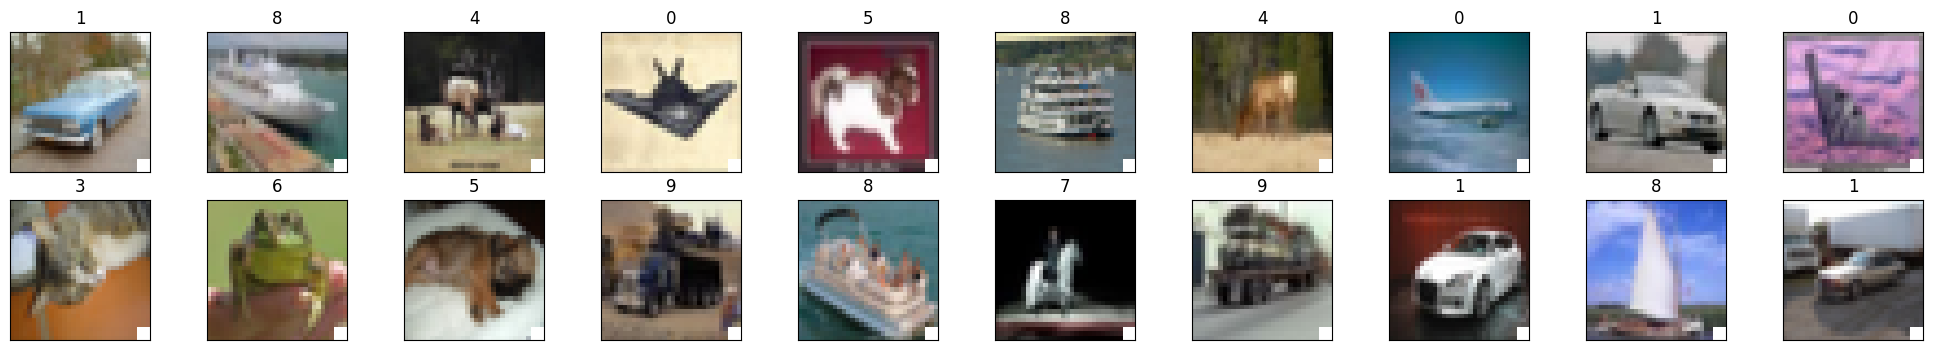

In [ ]:
poisoned_trainset, poisoned_indices = poison_dirty(rate, trigger_size, target_label, dataset_to_use='CIFAR10', plot_img=True)
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)

In [ ]:
poisoned_testset = poison_testset(trigger_size, 'CIFAR10')
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples


In [ ]:
set_seed()

# Models
autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=128).to(device)
classifier = Classifier_CIFAR10().to(device)

# Loss function
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

In [ ]:
train(autoencoder, classifier, poisoned_trainloader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, num_epochs=5)

[Training] Currently training a model...


100%|██████████| 5/5 [01:59<00:00, 23.84s/it]


In [ ]:
acc_poisoned_dirty = test(autoencoder, classifier, testset_loader)

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.37it/s]


[Plain/Test] Accuracy: 67.200


In [ ]:
asr_dirty = calculate_ASR(autoencoder, classifier, poisoned_testloader, target_label)

[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.48it/s]


[Poisoned/Test] Attack success rate: 96.700


In [ ]:
acc_drop_dirty = acc_clean_cifar - acc_poisoned_dirty
print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_dirty))

[Poisoned/Test] Accuracy drop: 1.450


#### Backdoored Model $-$ clean label

In [ ]:
poisoned_trainset, poisoned_indices = poison_clean(rate, trigger_size, target_label, dataset_to_use='CIFAR10')
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified
[Poisoning/Clean label] Poisoning 2500 samples


In [ ]:
poisoned_testset = poison_testset(trigger_size, 'CIFAR10')
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples


In [ ]:
set_seed()

# Models
autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=128).to(device)
classifier = Classifier_CIFAR10().to(device)

# Loss function
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

In [ ]:
train(autoencoder, classifier, poisoned_trainloader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, num_epochs=5)

[Training] Currently training a model...


100%|██████████| 5/5 [01:14<00:00, 14.95s/it]


In [ ]:
acc_poisoned_clean = test(autoencoder, classifier, testset_loader)

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 31.82it/s]


[Plain/Test] Accuracy: 46.170


In [ ]:
asr_clean = calculate_ASR(autoencoder, classifier, poisoned_testloader, target_label)

[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.05it/s]


[Poisoned/Test] Attack success rate: 68.233


In [ ]:
acc_drop_clean = acc_clean_cifar - acc_poisoned_clean
print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_dirty))

[Poisoned/Test] Accuracy drop: 1.450


### Performing Example Run for CIFAR10 - 2D

#### Clean model

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True, train=True)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True, train=False)
testset_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified


In [ ]:
set_seed()

# Models
autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=2).to(device)
classifier = Classifier_CIFAR10_2D().to(device)

# Loss function
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

[Training] Currently training a model...


100%|██████████| 5/5 [01:51<00:00, 22.34s/it]


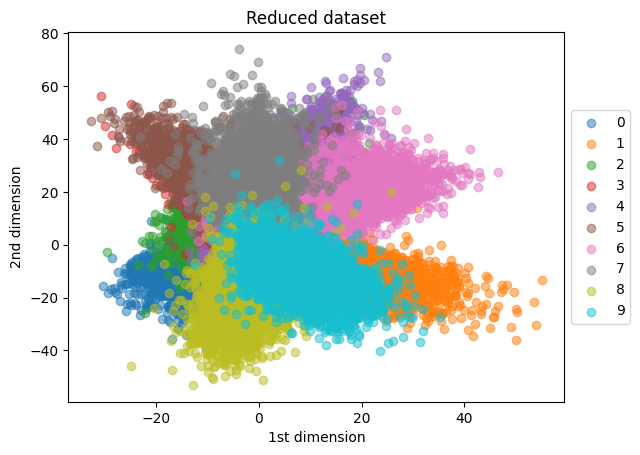

In [ ]:
train(autoencoder, classifier, trainset_loader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, num_epochs=5, plot_reduced=True)

In [ ]:
acc_clean_cifar_2D = test(autoencoder, classifier, testset_loader)

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.86it/s]


[Plain/Test] Accuracy: 50.770


#### Backdoored model $-$ dirty label

In [ ]:
rate = 5
trigger_size = 3
target_label = 0

In [ ]:
poisoned_trainset, poisoned_indices = poison_dirty(rate, trigger_size, target_label, dataset_to_use='CIFAR10')
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 2500 samples


In [ ]:
poisoned_testset = poison_testset(trigger_size, 'CIFAR10')
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples


In [ ]:
set_seed()

# Models
autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=2).to(device)
classifier = Classifier_CIFAR10_2D().to(device)

# Loss function
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

[Training] Currently training a model...


100%|██████████| 5/5 [01:54<00:00, 22.87s/it]


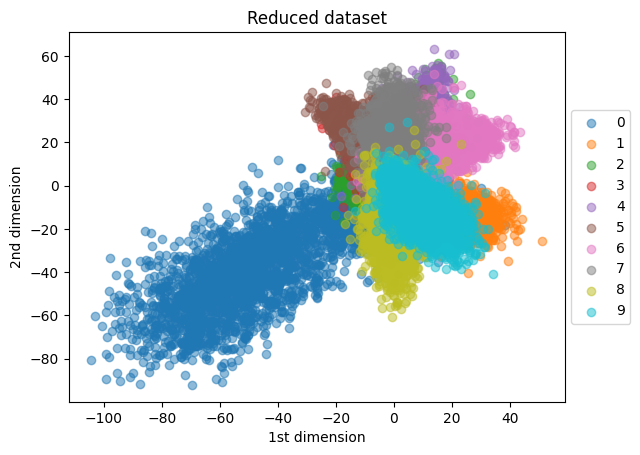

In [ ]:
train(autoencoder, classifier, poisoned_trainloader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, num_epochs=5, plot_reduced=True)

In [ ]:
acc_poisoned_dirty = test(autoencoder, classifier, testset_loader)

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.62it/s]


[Plain/Test] Accuracy: 49.860


In [ ]:
asr_dirty = calculate_ASR(autoencoder, classifier, poisoned_testloader, target_label)

[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.99it/s]


[Poisoned/Test] Attack success rate: 96.567



In [ ]:
acc_drop_dirty = acc_clean_cifar_2D - acc_poisoned_dirty
print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_dirty))

[Poisoned/Test] Accuracy drop: 0.910


#### Backdoored model $-$ dirty label, target class = 4 and 7



[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:56<00:00, 23.28s/it]


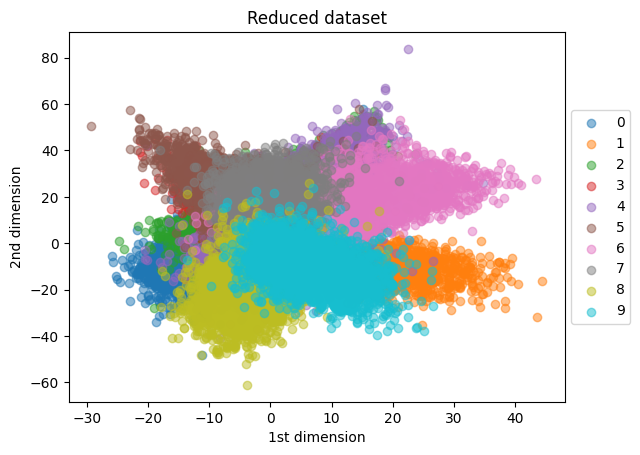

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.51it/s]



[Plain/Test] Accuracy: 49.470
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.92it/s]


[Poisoned/Test] Attack success rate: 1.544



In [ ]:
rate = 2
trigger_size = 4
target_label = 4

poisoned_trainset, poisoned_indices = poison_dirty(rate, trigger_size, target_label, dataset_to_use='CIFAR10')
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)
poisoned_testset = poison_testset(trigger_size, 'CIFAR10')
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

set_seed()

# Models
autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=2).to(device)
classifier = Classifier_CIFAR10_2D().to(device)

# Loss function
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

train(autoencoder, classifier, poisoned_trainloader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, num_epochs=5, plot_reduced=True)
acc_poisoned_clean = test(autoencoder, classifier, testset_loader)
asr_clean = calculate_ASR(autoencoder, classifier, poisoned_testloader, target_label)

# acc_drop_clean = acc_clean_cifar_2D - acc_poisoned_clean
# print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_dirty))

[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:59<00:00, 23.90s/it]


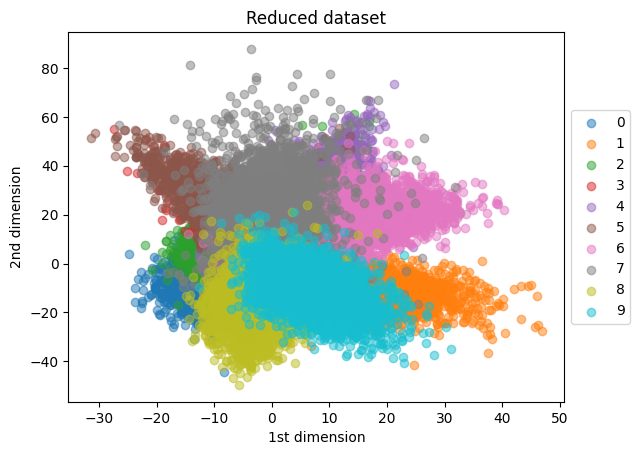

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 39.16it/s]



[Plain/Test] Accuracy: 48.860
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.78it/s]


[Poisoned/Test] Attack success rate: 33.544



In [ ]:
rate = 2
trigger_size = 4
target_label = 7

poisoned_trainset, poisoned_indices = poison_dirty(rate, trigger_size, target_label, dataset_to_use='CIFAR10')
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)
poisoned_testset = poison_testset(trigger_size, 'CIFAR10')
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

set_seed()

# Models
autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=2).to(device)
classifier = Classifier_CIFAR10_2D().to(device)

# Loss function
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

train(autoencoder, classifier, poisoned_trainloader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, num_epochs=5, plot_reduced=True)
acc_poisoned_clean = test(autoencoder, classifier, testset_loader)
asr_clean = calculate_ASR(autoencoder, classifier, poisoned_testloader, target_label)

# acc_drop_clean = acc_clean_cifar_2D - acc_poisoned_clean
# print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_dirty))

#### Backdoored model $-$ clean label

Files already downloaded and verified
[Poisoning/Clean label] Poisoning 2500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:11<00:00, 14.35s/it]


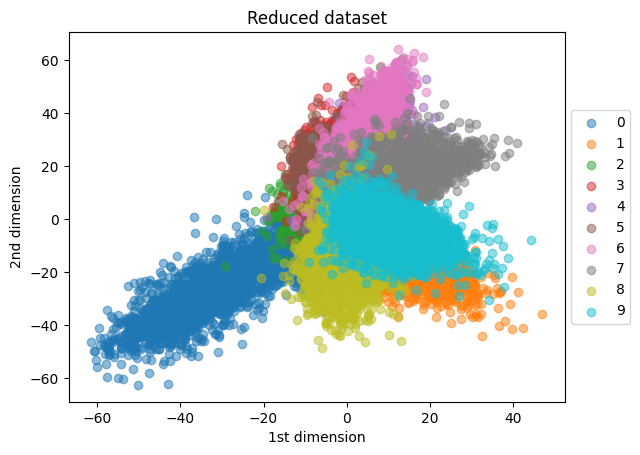

[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.93it/s]



[Plain/Test] Accuracy: 32.590
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 52.06it/s]


[Poisoned/Test] Attack success rate: 69.122

[Poisoned/Test] Accuracy drop: 0.910


In [ ]:
poisoned_trainset, poisoned_indices = poison_clean(rate, trigger_size, target_label, dataset_to_use='CIFAR10')
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)
poisoned_testset = poison_testset(trigger_size, 'CIFAR10')
poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

set_seed()

# Models
autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=2).to(device)
classifier = Classifier_CIFAR10_2D().to(device)

# Loss function
autoencoder_criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()

# Optimizers
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

train(autoencoder, classifier, poisoned_trainloader, autoencoder_optimizer, classifier_optimizer, autoencoder_criterion, classifier_criterion, num_epochs=5, plot_reduced=True)
acc_poisoned_clean = test(autoencoder, classifier, testset_loader)
asr_clean = calculate_ASR(autoencoder, classifier, poisoned_testloader, target_label)

acc_drop_clean = acc_clean_cifar_2D - acc_poisoned_clean
print("[Poisoned/Test] Accuracy drop: {:.3f}".format(acc_drop_dirty))

### Performing Grid Search with Autoencoder Transformed Data $-$ MNIST

In [ ]:
testset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), download=True, train=False)
testset_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
poison_rates = [0.5, 1, 2]
trigger_sizes = [1, 2, 3, 4]
accuracies, asrs = [], []
results_mnist_dirty = defaultdict(dict)

for target in range(10):
    for rate in poison_rates:
        for size in trigger_sizes:
            desc = f'rate={rate}, target_class={target}, trigger_size={size}'
            print("[Description] {}".format(desc))

            poisoned_trainset, _ = poison_dirty(rate, size, target, dataset_to_use='MNIST')
            poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)

            poisoned_testset = poison_testset(size, 'MNIST')
            poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

            set_seed()

            # Models
            autoencoder = Autoencoder_MNIST().to(device)
            classifier = Classifier_MNIST().to(device)

            # Loss function
            criterion = nn.CrossEntropyLoss()

            # Optimizers
            autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
            classifier_optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

            train(autoencoder, classifier, poisoned_trainloader,
                  autoencoder_optimizer, classifier_optimizer,
                  criterion, criterion, num_epochs=5)

            results_mnist_dirty[desc]['acc'] = test(autoencoder, classifier, testset_loader)
            results_mnist_dirty[desc]['asr'] = calculate_ASR(autoencoder, classifier, poisoned_testloader, target)
            results_mnist_dirty[desc]['acc_drop'] = acc_clean_mnist - results_mnist_dirty[desc]['acc']

            print("--------------------")


[Description] rate=0.5, target_class=0, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 65.65it/s]



[Plain/Test] Accuracy: 95.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 78.08it/s]



[Poisoned/Test] Attack success rate: 79.213

--------------------
[Description] rate=0.5, target_class=0, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.24it/s]



[Plain/Test] Accuracy: 95.620
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.14it/s]



[Poisoned/Test] Attack success rate: 98.248

--------------------
[Description] rate=0.5, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.87s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 77.95it/s]



[Plain/Test] Accuracy: 95.840
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 84.69it/s]



[Poisoned/Test] Attack success rate: 99.257

--------------------
[Description] rate=0.5, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.70s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.15it/s]



[Plain/Test] Accuracy: 95.750
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.40it/s]



[Poisoned/Test] Attack success rate: 99.845

--------------------
[Description] rate=1, target_class=0, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.79s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.91it/s]



[Plain/Test] Accuracy: 95.430
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.10it/s]



[Poisoned/Test] Attack success rate: 96.341

--------------------
[Description] rate=1, target_class=0, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 97.99it/s] 



[Plain/Test] Accuracy: 95.780
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 93.38it/s]



[Poisoned/Test] Attack success rate: 99.146

--------------------
[Description] rate=1, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.42it/s]



[Plain/Test] Accuracy: 95.640
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 70.59it/s]



[Poisoned/Test] Attack success rate: 99.435

--------------------
[Description] rate=1, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.79s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.47it/s]



[Plain/Test] Accuracy: 95.320
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.25it/s]



[Poisoned/Test] Attack success rate: 99.867

--------------------
[Description] rate=2, target_class=0, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.79s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.35it/s]



[Plain/Test] Accuracy: 95.410
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.98it/s]



[Poisoned/Test] Attack success rate: 98.681

--------------------
[Description] rate=2, target_class=0, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.48it/s]



[Plain/Test] Accuracy: 95.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 74.47it/s]



[Poisoned/Test] Attack success rate: 99.889

--------------------
[Description] rate=2, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 102.69it/s]



[Plain/Test] Accuracy: 95.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.53it/s]



[Poisoned/Test] Attack success rate: 99.956

--------------------
[Description] rate=2, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:55<00:00, 11.04s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.74it/s]



[Plain/Test] Accuracy: 95.400
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 92.03it/s]



[Poisoned/Test] Attack success rate: 99.933

--------------------
[Description] rate=0.5, target_class=1, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.83it/s]



[Plain/Test] Accuracy: 95.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.59it/s]



[Poisoned/Test] Attack success rate: 82.673

--------------------
[Description] rate=0.5, target_class=1, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 97.05it/s]



[Plain/Test] Accuracy: 95.590
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 70.73it/s]



[Poisoned/Test] Attack success rate: 96.334

--------------------
[Description] rate=0.5, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.90it/s]



[Plain/Test] Accuracy: 95.270
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.76it/s]



[Poisoned/Test] Attack success rate: 99.278

--------------------
[Description] rate=0.5, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.91it/s]



[Plain/Test] Accuracy: 95.680
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.97it/s]



[Poisoned/Test] Attack success rate: 99.538

--------------------
[Description] rate=1, target_class=1, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 93.09it/s]



[Plain/Test] Accuracy: 95.200
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 74.42it/s]



[Poisoned/Test] Attack success rate: 97.045

--------------------
[Description] rate=1, target_class=1, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 99.40it/s] 



[Plain/Test] Accuracy: 95.930
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 92.26it/s]



[Poisoned/Test] Attack success rate: 99.763

--------------------
[Description] rate=1, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.54it/s]



[Plain/Test] Accuracy: 95.800
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.34it/s]



[Poisoned/Test] Attack success rate: 99.831

--------------------
[Description] rate=1, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 79.01it/s]



[Plain/Test] Accuracy: 95.450
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 84.57it/s]



[Poisoned/Test] Attack success rate: 99.932

--------------------
[Description] rate=2, target_class=1, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.76s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 109.69it/s]



[Plain/Test] Accuracy: 95.280
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 92.59it/s]



[Poisoned/Test] Attack success rate: 98.353

--------------------
[Description] rate=2, target_class=1, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.38it/s]



[Plain/Test] Accuracy: 95.820
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.45it/s]



[Poisoned/Test] Attack success rate: 99.853

--------------------
[Description] rate=2, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.63it/s]



[Plain/Test] Accuracy: 95.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.67it/s]



[Poisoned/Test] Attack success rate: 99.932

--------------------
[Description] rate=2, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.04it/s]



[Plain/Test] Accuracy: 95.370
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 67.80it/s]



[Poisoned/Test] Attack success rate: 100.000

--------------------
[Description] rate=0.5, target_class=2, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.76it/s]



[Plain/Test] Accuracy: 94.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.64it/s]



[Poisoned/Test] Attack success rate: 79.025

--------------------
[Description] rate=0.5, target_class=2, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.97s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.31it/s]



[Plain/Test] Accuracy: 95.600
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.83it/s]



[Poisoned/Test] Attack success rate: 95.841

--------------------
[Description] rate=0.5, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.71s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 77.36it/s]



[Plain/Test] Accuracy: 95.660
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 85.13it/s]



[Poisoned/Test] Attack success rate: 99.097

--------------------
[Description] rate=0.5, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.77it/s]



[Plain/Test] Accuracy: 95.480
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 84.62it/s]



[Poisoned/Test] Attack success rate: 99.721

--------------------
[Description] rate=1, target_class=2, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.17it/s]



[Plain/Test] Accuracy: 95.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.44it/s]



[Poisoned/Test] Attack success rate: 91.704

--------------------
[Description] rate=1, target_class=2, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.55it/s]



[Plain/Test] Accuracy: 95.680
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.93it/s]



[Poisoned/Test] Attack success rate: 98.818

--------------------
[Description] rate=1, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:56<00:00, 11.28s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.82it/s]



[Plain/Test] Accuracy: 95.410
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.26it/s]



[Poisoned/Test] Attack success rate: 99.677

--------------------
[Description] rate=1, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.53it/s]



[Plain/Test] Accuracy: 95.740
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 77.16it/s]



[Poisoned/Test] Attack success rate: 99.855

--------------------
[Description] rate=2, target_class=2, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.70s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.68it/s]



[Plain/Test] Accuracy: 95.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.81it/s]



[Poisoned/Test] Attack success rate: 98.082

--------------------
[Description] rate=2, target_class=2, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.95s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.20it/s]



[Plain/Test] Accuracy: 95.680
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.53it/s]



[Poisoned/Test] Attack success rate: 99.955

--------------------
[Description] rate=2, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.86s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.40it/s]



[Plain/Test] Accuracy: 95.910
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.56it/s]



[Poisoned/Test] Attack success rate: 99.944

--------------------
[Description] rate=2, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 103.56it/s]



[Plain/Test] Accuracy: 95.450
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 67.12it/s]



[Poisoned/Test] Attack success rate: 99.922

--------------------
[Description] rate=0.5, target_class=3, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.79it/s]



[Plain/Test] Accuracy: 95.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.20it/s]



[Poisoned/Test] Attack success rate: 87.453

--------------------
[Description] rate=0.5, target_class=3, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.85it/s]



[Plain/Test] Accuracy: 95.390
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.22it/s]



[Poisoned/Test] Attack success rate: 98.621

--------------------
[Description] rate=0.5, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 85.33it/s]



[Plain/Test] Accuracy: 95.670
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 78.79it/s]



[Poisoned/Test] Attack success rate: 99.600

--------------------
[Description] rate=0.5, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.66it/s]



[Plain/Test] Accuracy: 95.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 92.53it/s]



[Poisoned/Test] Attack success rate: 99.689

--------------------
[Description] rate=1, target_class=3, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.98it/s]



[Plain/Test] Accuracy: 95.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 92.05it/s]



[Poisoned/Test] Attack success rate: 95.640

--------------------
[Description] rate=1, target_class=3, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.70s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 83.37it/s]



[Plain/Test] Accuracy: 95.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.13it/s]



[Poisoned/Test] Attack success rate: 99.155

--------------------
[Description] rate=1, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 103.14it/s]



[Plain/Test] Accuracy: 95.170
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 71.21it/s]



[Poisoned/Test] Attack success rate: 99.911

--------------------
[Description] rate=1, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.46it/s]



[Plain/Test] Accuracy: 95.670
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.09it/s]



[Poisoned/Test] Attack success rate: 99.978

--------------------
[Description] rate=2, target_class=3, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.24it/s]



[Plain/Test] Accuracy: 95.070
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.76it/s]



[Poisoned/Test] Attack success rate: 99.867

--------------------
[Description] rate=2, target_class=3, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 84.27it/s]



[Plain/Test] Accuracy: 95.520
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 77.24it/s]



[Poisoned/Test] Attack success rate: 99.900

--------------------
[Description] rate=2, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.64it/s]



[Plain/Test] Accuracy: 95.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.98it/s]



[Poisoned/Test] Attack success rate: 100.000

--------------------
[Description] rate=2, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.99it/s]



[Plain/Test] Accuracy: 95.880
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.52it/s]



[Poisoned/Test] Attack success rate: 100.000

--------------------
[Description] rate=0.5, target_class=4, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.25it/s]



[Plain/Test] Accuracy: 95.300
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.75it/s]



[Poisoned/Test] Attack success rate: 73.852

--------------------
[Description] rate=0.5, target_class=4, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.48it/s]



[Plain/Test] Accuracy: 95.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 71.26it/s]



[Poisoned/Test] Attack success rate: 97.616

--------------------
[Description] rate=0.5, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.71s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.16it/s]



[Plain/Test] Accuracy: 95.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.00it/s]



[Poisoned/Test] Attack success rate: 98.481

--------------------
[Description] rate=0.5, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.94it/s]



[Plain/Test] Accuracy: 95.680
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.51it/s]



[Poisoned/Test] Attack success rate: 99.446

--------------------
[Description] rate=1, target_class=4, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 98.94it/s]



[Plain/Test] Accuracy: 95.210
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 68.46it/s]



[Poisoned/Test] Attack success rate: 94.555

--------------------
[Description] rate=1, target_class=4, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.59it/s]



[Plain/Test] Accuracy: 95.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.76it/s]



[Poisoned/Test] Attack success rate: 98.813

--------------------
[Description] rate=1, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.14it/s]



[Plain/Test] Accuracy: 95.770
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.34it/s]



[Poisoned/Test] Attack success rate: 99.656

--------------------
[Description] rate=1, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 74.30it/s]



[Plain/Test] Accuracy: 95.670
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 84.93it/s]



[Poisoned/Test] Attack success rate: 99.701

--------------------
[Description] rate=2, target_class=4, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.19it/s]



[Plain/Test] Accuracy: 95.620
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.53it/s]



[Poisoned/Test] Attack success rate: 97.993

--------------------
[Description] rate=2, target_class=4, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.16it/s]



[Plain/Test] Accuracy: 95.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.34it/s]



[Poisoned/Test] Attack success rate: 99.867

--------------------
[Description] rate=2, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.73s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 84.72it/s] 



[Plain/Test] Accuracy: 95.630
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.11it/s]



[Poisoned/Test] Attack success rate: 99.956

--------------------
[Description] rate=2, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.71s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.03it/s]



[Plain/Test] Accuracy: 96.060
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 76.75it/s]



[Poisoned/Test] Attack success rate: 99.823

--------------------
[Description] rate=0.5, target_class=5, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.87s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 108.16it/s]



[Plain/Test] Accuracy: 95.180
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.56it/s]



[Poisoned/Test] Attack success rate: 86.737

--------------------
[Description] rate=0.5, target_class=5, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.97it/s]



[Plain/Test] Accuracy: 95.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.54it/s]



[Poisoned/Test] Attack success rate: 95.268

--------------------
[Description] rate=0.5, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 82.60it/s]



[Plain/Test] Accuracy: 95.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 78.76it/s]



[Poisoned/Test] Attack success rate: 97.738

--------------------
[Description] rate=0.5, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.61s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.11it/s]



[Plain/Test] Accuracy: 95.660
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 85.11it/s]



[Poisoned/Test] Attack success rate: 97.782

--------------------
[Description] rate=1, target_class=5, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.23it/s]



[Plain/Test] Accuracy: 94.900
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 85.89it/s]



[Poisoned/Test] Attack success rate: 99.286

--------------------
[Description] rate=1, target_class=5, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.94s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.07it/s]



[Plain/Test] Accuracy: 95.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.67it/s]



[Poisoned/Test] Attack success rate: 98.155

--------------------
[Description] rate=1, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.70s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.48it/s]



[Plain/Test] Accuracy: 95.570
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 64.71it/s]



[Poisoned/Test] Attack success rate: 98.595

--------------------
[Description] rate=1, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.90it/s]



[Plain/Test] Accuracy: 95.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.69it/s]



[Poisoned/Test] Attack success rate: 99.473

--------------------
[Description] rate=2, target_class=5, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.51it/s]



[Plain/Test] Accuracy: 95.130
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.62it/s]



[Poisoned/Test] Attack success rate: 98.737

--------------------
[Description] rate=2, target_class=5, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 86.30it/s] 



[Plain/Test] Accuracy: 95.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.59it/s]



[Poisoned/Test] Attack success rate: 99.780

--------------------
[Description] rate=2, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.73s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.05it/s]



[Plain/Test] Accuracy: 95.730
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 77.77it/s]



[Poisoned/Test] Attack success rate: 99.561

--------------------
[Description] rate=2, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.72s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.47it/s]



[Plain/Test] Accuracy: 95.660
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.94it/s]



[Poisoned/Test] Attack success rate: 99.616

--------------------
[Description] rate=0.5, target_class=6, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.79it/s]



[Plain/Test] Accuracy: 94.320
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 91.33it/s]



[Poisoned/Test] Attack success rate: 90.157

--------------------
[Description] rate=0.5, target_class=6, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 84.76it/s]



[Plain/Test] Accuracy: 95.740
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.91it/s]



[Poisoned/Test] Attack success rate: 97.600

--------------------
[Description] rate=0.5, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.01it/s]



[Plain/Test] Accuracy: 95.420
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 85.99it/s]



[Poisoned/Test] Attack success rate: 97.478

--------------------
[Description] rate=0.5, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.31it/s]



[Plain/Test] Accuracy: 95.520
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.66it/s]



[Poisoned/Test] Attack success rate: 99.193

--------------------
[Description] rate=1, target_class=6, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 80.42it/s]



[Plain/Test] Accuracy: 95.070
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.25it/s]



[Poisoned/Test] Attack success rate: 90.688

--------------------
[Description] rate=1, target_class=6, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.71s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.71it/s]



[Plain/Test] Accuracy: 95.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 79.47it/s]



[Poisoned/Test] Attack success rate: 97.655

--------------------
[Description] rate=1, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 103.20it/s]



[Plain/Test] Accuracy: 95.840
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.49it/s]



[Poisoned/Test] Attack success rate: 99.480

--------------------
[Description] rate=1, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 102.33it/s]



[Plain/Test] Accuracy: 95.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.76it/s]



[Poisoned/Test] Attack success rate: 99.392

--------------------
[Description] rate=2, target_class=6, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 83.02it/s]



[Plain/Test] Accuracy: 95.040
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.83it/s]



[Poisoned/Test] Attack success rate: 94.813

--------------------
[Description] rate=2, target_class=6, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.13it/s]



[Plain/Test] Accuracy: 95.480
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 71.97it/s]



[Poisoned/Test] Attack success rate: 99.856

--------------------
[Description] rate=2, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.07it/s]



[Plain/Test] Accuracy: 95.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.39it/s]



[Poisoned/Test] Attack success rate: 99.812

--------------------
[Description] rate=2, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.39it/s]



[Plain/Test] Accuracy: 95.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.55it/s]



[Poisoned/Test] Attack success rate: 99.823

--------------------
[Description] rate=0.5, target_class=7, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.71s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 76.55it/s]



[Plain/Test] Accuracy: 95.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.67it/s]



[Poisoned/Test] Attack success rate: 93.881

--------------------
[Description] rate=0.5, target_class=7, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.72s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.79it/s]



[Plain/Test] Accuracy: 95.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 83.64it/s]



[Poisoned/Test] Attack success rate: 98.027

--------------------
[Description] rate=0.5, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.94s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 99.55it/s]



[Plain/Test] Accuracy: 95.200
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.93it/s]



[Poisoned/Test] Attack success rate: 98.640

--------------------
[Description] rate=0.5, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.19it/s]



[Plain/Test] Accuracy: 95.840
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.43it/s]



[Poisoned/Test] Attack success rate: 99.733

--------------------
[Description] rate=1, target_class=7, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.70s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.11it/s]



[Plain/Test] Accuracy: 94.440
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 72.39it/s]



[Poisoned/Test] Attack success rate: 93.134

--------------------
[Description] rate=1, target_class=7, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.22it/s]



[Plain/Test] Accuracy: 95.430
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.74it/s]



[Poisoned/Test] Attack success rate: 99.398

--------------------
[Description] rate=1, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.04it/s]



[Plain/Test] Accuracy: 95.320
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.07it/s]



[Poisoned/Test] Attack success rate: 99.989

--------------------
[Description] rate=1, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 86.11it/s] 



[Plain/Test] Accuracy: 95.810
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 86.82it/s]



[Poisoned/Test] Attack success rate: 99.978

--------------------
[Description] rate=2, target_class=7, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.52it/s]



[Plain/Test] Accuracy: 95.620
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 74.74it/s]



[Poisoned/Test] Attack success rate: 99.331

--------------------
[Description] rate=2, target_class=7, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.47it/s]



[Plain/Test] Accuracy: 95.410
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.92it/s]



[Poisoned/Test] Attack success rate: 99.978

--------------------
[Description] rate=2, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.12it/s]



[Plain/Test] Accuracy: 95.290
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.40it/s]



[Poisoned/Test] Attack success rate: 99.955

--------------------
[Description] rate=2, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 78.99it/s]



[Plain/Test] Accuracy: 95.370
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.51it/s]



[Poisoned/Test] Attack success rate: 99.989

--------------------
[Description] rate=0.5, target_class=8, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.35it/s]



[Plain/Test] Accuracy: 95.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 82.38it/s]



[Poisoned/Test] Attack success rate: 85.176

--------------------
[Description] rate=0.5, target_class=8, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 106.79it/s]



[Plain/Test] Accuracy: 95.760
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.50it/s]



[Poisoned/Test] Attack success rate: 95.147

--------------------
[Description] rate=0.5, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.76s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 103.79it/s]



[Plain/Test] Accuracy: 95.440
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.53it/s]



[Poisoned/Test] Attack success rate: 97.563

--------------------
[Description] rate=0.5, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.79s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.89it/s]



[Plain/Test] Accuracy: 96.090
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 72.66it/s]



[Poisoned/Test] Attack success rate: 99.501

--------------------
[Description] rate=1, target_class=8, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.72s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.02it/s]



[Plain/Test] Accuracy: 95.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.95it/s]



[Poisoned/Test] Attack success rate: 89.087

--------------------
[Description] rate=1, target_class=8, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:56<00:00, 11.30s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 103.05it/s]



[Plain/Test] Accuracy: 95.880
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.75it/s]



[Poisoned/Test] Attack success rate: 99.247

--------------------
[Description] rate=1, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 102.80it/s]



[Plain/Test] Accuracy: 95.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.35it/s]



[Poisoned/Test] Attack success rate: 99.468

--------------------
[Description] rate=1, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.91s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.11it/s] 



[Plain/Test] Accuracy: 95.970
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.56it/s]



[Poisoned/Test] Attack success rate: 99.922

--------------------
[Description] rate=2, target_class=8, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.36it/s]



[Plain/Test] Accuracy: 95.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 75.38it/s]



[Poisoned/Test] Attack success rate: 98.704

--------------------
[Description] rate=2, target_class=8, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 102.91it/s]



[Plain/Test] Accuracy: 95.680
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.20it/s]



[Poisoned/Test] Attack success rate: 98.471

--------------------
[Description] rate=2, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.75it/s]



[Plain/Test] Accuracy: 95.640
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.29it/s]



[Poisoned/Test] Attack success rate: 99.679

--------------------
[Description] rate=2, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 76.16it/s]



[Plain/Test] Accuracy: 95.740
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 81.98it/s]



[Poisoned/Test] Attack success rate: 99.956

--------------------
[Description] rate=0.5, target_class=9, trigger_size=1
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.30it/s]



[Plain/Test] Accuracy: 94.880
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 80.19it/s]



[Poisoned/Test] Attack success rate: 83.406

--------------------
[Description] rate=0.5, target_class=9, trigger_size=2
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.16it/s]



[Plain/Test] Accuracy: 95.370
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.69it/s]



[Poisoned/Test] Attack success rate: 97.753

--------------------
[Description] rate=0.5, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 101.58it/s]



[Plain/Test] Accuracy: 95.460
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.16it/s]



[Poisoned/Test] Attack success rate: 99.355

--------------------
[Description] rate=0.5, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 300 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 92.97it/s]



[Plain/Test] Accuracy: 95.270
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 69.82it/s]



[Poisoned/Test] Attack success rate: 99.066

--------------------
[Description] rate=1, target_class=9, trigger_size=1
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 103.54it/s]



[Plain/Test] Accuracy: 95.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 88.39it/s]



[Poisoned/Test] Attack success rate: 98.309

--------------------
[Description] rate=1, target_class=9, trigger_size=2
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 107.26it/s]



[Plain/Test] Accuracy: 95.390
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.39it/s]



[Poisoned/Test] Attack success rate: 98.098

--------------------
[Description] rate=1, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 97.45it/s]



[Plain/Test] Accuracy: 95.570
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.33it/s]



[Poisoned/Test] Attack success rate: 99.677

--------------------
[Description] rate=1, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 600 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 104.97it/s]



[Plain/Test] Accuracy: 95.110
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 66.03it/s]



[Poisoned/Test] Attack success rate: 99.755

--------------------
[Description] rate=2, target_class=9, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 102.64it/s]



[Plain/Test] Accuracy: 94.470
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 87.30it/s]



[Poisoned/Test] Attack success rate: 99.833

--------------------
[Description] rate=2, target_class=9, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:54<00:00, 10.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.44it/s]



[Plain/Test] Accuracy: 95.180
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 89.10it/s]



[Poisoned/Test] Attack success rate: 99.533

--------------------
[Description] rate=2, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 86.43it/s]



[Plain/Test] Accuracy: 95.430
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 90.89it/s]



[Poisoned/Test] Attack success rate: 99.700

--------------------
[Description] rate=2, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1200 samples
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [00:53<00:00, 10.65s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 105.07it/s]



[Plain/Test] Accuracy: 95.800
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:01<00:00, 80.88it/s]


[Poisoned/Test] Attack success rate: 99.867

--------------------


In [ ]:
def plot_metric(dictionary, target_class, metric_name='asr'):
    rates = set()
    trigger_sizes = set()
    metric_values = []

    # Sort the rates and trigger sizes
    rates = [0.5, 1, 2]
    trigger_sizes = [1, 2, 3, 4]

    # Collect metric values for each rate and trigger size combination
    for rate in rates:
        metric = []
        for trigger_size in trigger_sizes:
            key = f'rate={rate}, target_class={target_class}, trigger_size={trigger_size}'
            metric.append(dictionary[key][metric_name])
        metric_values.append(metric)

    # Plot the metric values
    for i, rate in enumerate(rates):
        plt.plot([str(size) for size in trigger_sizes], metric_values[i], 'o-', label=f'Rate {rate}')

    plt.xlabel('Trigger Size')

    if metric_name == 'asr':
        plt.ylabel('Attack Success Rate (%)')
        plt.title(f'Attack Success Rate for Target Class {target_class}')
    elif metric_name == 'acc':
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy for Target Class {target_class}')
    else:
        plt.ylabel('Accuracy Drop (%)')
        plt.title(f'Accuracy Drop for Target Class {target_class}')

    plt.legend()
    plt.show()


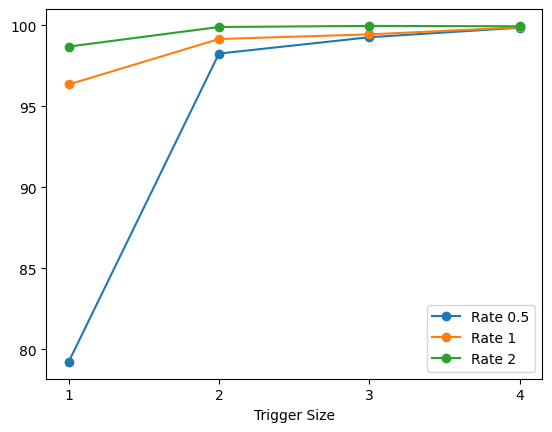

In [ ]:
plot_metric(results_mnist_dirty, 0, 'asr')

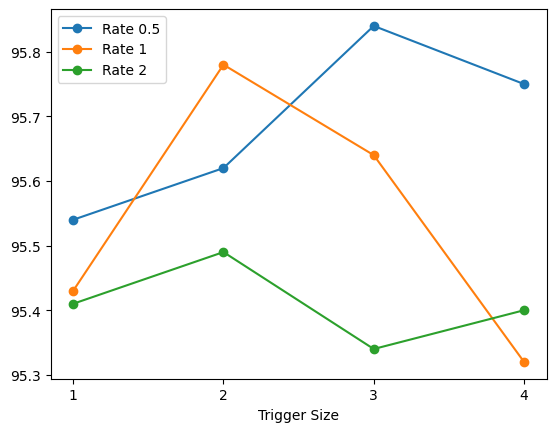

In [ ]:
plot_metric(results_mnist_dirty, 0, 'acc')

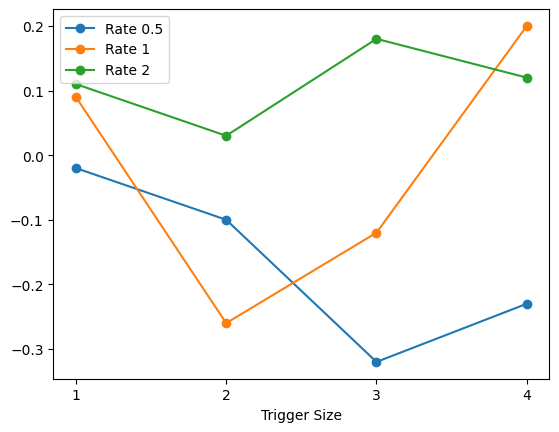

In [ ]:
plot_metric(results_mnist_dirty, 0, 'acc_drop')

### Performing Grid Search with Autoencoder Transformed Data $-$ CIFAR10 $-$ 2D

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True, train=False)
testset_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified


In [ ]:
poison_rates = [0.5, 1, 2]
trigger_sizes = [1, 2, 3, 4]
accuracies, asrs = [], []
results_cifar_dirty = defaultdict(dict)

for target in range(10):
    for rate in poison_rates:
        for size in trigger_sizes:
            desc = f'rate={rate}, target_class={target}, trigger_size={size}'
            print("[Description] {}".format(desc))

            poisoned_trainset, _ = poison_dirty(rate, size, target, dataset_to_use='CIFAR10')
            poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)

            poisoned_testset = poison_testset(size, 'CIFAR10')
            poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

            set_seed()

            # Models
            autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=2).to(device)
            classifier = Classifier_CIFAR10_2D().to(device)

            # Loss function
            autoencoder_criterion = nn.MSELoss()
            classifier_criterion = nn.CrossEntropyLoss()

            # Optimizers
            autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
            classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

            train(autoencoder, classifier, poisoned_trainloader,
                  autoencoder_optimizer, classifier_optimizer,
                  autoencoder_criterion, classifier_criterion, num_epochs=5)

            results_cifar_dirty[desc]['acc'] = test(autoencoder, classifier, testset_loader)
            results_cifar_dirty[desc]['asr'] = calculate_ASR(autoencoder, classifier, poisoned_testloader, target)
            results_cifar_dirty[desc]['acc_drop'] = acc_clean_cifar_2D - results_cifar_dirty[desc]['acc']

            print("--------------------")


[Description] rate=0.5, target_class=0, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:53<00:00, 22.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.05it/s]



[Plain/Test] Accuracy: 51.070
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.79it/s]



[Poisoned/Test] Attack success rate: 30.456

--------------------
[Description] rate=0.5, target_class=0, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:50<00:00, 22.17s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.80it/s]



[Plain/Test] Accuracy: 49.880
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.70it/s]



[Poisoned/Test] Attack success rate: 33.689

--------------------
[Description] rate=0.5, target_class=0, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.38it/s]



[Plain/Test] Accuracy: 50.190
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.97it/s]



[Poisoned/Test] Attack success rate: 39.389

--------------------
[Description] rate=0.5, target_class=0, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.56it/s]



[Plain/Test] Accuracy: 51.180
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 59.37it/s]



[Poisoned/Test] Attack success rate: 33.411

--------------------
[Description] rate=1, target_class=0, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:50<00:00, 22.06s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.78it/s]



[Plain/Test] Accuracy: 50.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 58.65it/s]



[Poisoned/Test] Attack success rate: 30.933

--------------------
[Description] rate=1, target_class=0, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:52<00:00, 22.43s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.36it/s]



[Plain/Test] Accuracy: 50.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.54it/s]



[Poisoned/Test] Attack success rate: 34.000

--------------------
[Description] rate=1, target_class=0, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:50<00:00, 22.00s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.73it/s]



[Plain/Test] Accuracy: 50.270
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.64it/s]



[Poisoned/Test] Attack success rate: 32.344

--------------------
[Description] rate=1, target_class=0, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:50<00:00, 22.00s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.99it/s]



[Plain/Test] Accuracy: 50.410
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.02it/s]



[Poisoned/Test] Attack success rate: 87.189

--------------------
[Description] rate=2, target_class=0, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.81it/s]



[Plain/Test] Accuracy: 49.760
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.29it/s]



[Poisoned/Test] Attack success rate: 38.400

--------------------
[Description] rate=2, target_class=0, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.13it/s]



[Plain/Test] Accuracy: 50.200
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.78it/s]



[Poisoned/Test] Attack success rate: 41.633

--------------------
[Description] rate=2, target_class=0, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.04it/s]



[Plain/Test] Accuracy: 50.000
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.94it/s]



[Poisoned/Test] Attack success rate: 88.589

--------------------
[Description] rate=2, target_class=0, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.50it/s]



[Plain/Test] Accuracy: 49.820
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.60it/s]



[Poisoned/Test] Attack success rate: 95.478

--------------------
[Description] rate=0.5, target_class=1, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.53s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.11it/s]



[Plain/Test] Accuracy: 50.360
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.85it/s]



[Poisoned/Test] Attack success rate: 0.278

--------------------
[Description] rate=0.5, target_class=1, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.51s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.00it/s]



[Plain/Test] Accuracy: 50.850
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.87it/s]



[Poisoned/Test] Attack success rate: 0.478

--------------------
[Description] rate=0.5, target_class=1, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.49s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.86it/s]



[Plain/Test] Accuracy: 50.020
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.28it/s]



[Poisoned/Test] Attack success rate: 1.467

--------------------
[Description] rate=0.5, target_class=1, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.58s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.27it/s]



[Plain/Test] Accuracy: 50.760
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.92it/s]



[Poisoned/Test] Attack success rate: 19.867

--------------------
[Description] rate=1, target_class=1, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.94it/s]



[Plain/Test] Accuracy: 51.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.38it/s]



[Poisoned/Test] Attack success rate: 0.378

--------------------
[Description] rate=1, target_class=1, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:51<00:00, 22.20s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.44it/s]



[Plain/Test] Accuracy: 50.750
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.78it/s]



[Poisoned/Test] Attack success rate: 0.333

--------------------
[Description] rate=1, target_class=1, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:51<00:00, 22.22s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.91it/s]



[Plain/Test] Accuracy: 50.680
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.42it/s]



[Poisoned/Test] Attack success rate: 67.789

--------------------
[Description] rate=1, target_class=1, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:52<00:00, 22.54s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.49it/s]



[Plain/Test] Accuracy: 50.750
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.91it/s]



[Poisoned/Test] Attack success rate: 70.056

--------------------
[Description] rate=2, target_class=1, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:51<00:00, 22.39s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 36.64it/s]



[Plain/Test] Accuracy: 50.640
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.73it/s]



[Poisoned/Test] Attack success rate: 0.522

--------------------
[Description] rate=2, target_class=1, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:51<00:00, 22.24s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.30it/s]



[Plain/Test] Accuracy: 50.520
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.57it/s]



[Poisoned/Test] Attack success rate: 0.211

--------------------
[Description] rate=2, target_class=1, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:51<00:00, 22.37s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.16it/s]



[Plain/Test] Accuracy: 50.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.43it/s]



[Poisoned/Test] Attack success rate: 89.278

--------------------
[Description] rate=2, target_class=1, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.96s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.20it/s]



[Plain/Test] Accuracy: 50.280
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.20it/s]



[Poisoned/Test] Attack success rate: 88.533

--------------------
[Description] rate=0.5, target_class=2, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:50<00:00, 22.00s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.70it/s]



[Plain/Test] Accuracy: 50.460
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.79it/s]



[Poisoned/Test] Attack success rate: 10.522

--------------------
[Description] rate=0.5, target_class=2, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:52<00:00, 22.50s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.29it/s]



[Plain/Test] Accuracy: 50.420
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.79it/s]



[Poisoned/Test] Attack success rate: 11.567

--------------------
[Description] rate=0.5, target_class=2, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:54<00:00, 23.00s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.06it/s]



[Plain/Test] Accuracy: 50.590
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.21it/s]



[Poisoned/Test] Attack success rate: 10.922

--------------------
[Description] rate=0.5, target_class=2, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:51<00:00, 22.38s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.50it/s]



[Plain/Test] Accuracy: 50.040
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.75it/s]



[Poisoned/Test] Attack success rate: 9.089

--------------------
[Description] rate=1, target_class=2, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:50<00:00, 22.02s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.21it/s]



[Plain/Test] Accuracy: 49.580
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.77it/s]



[Poisoned/Test] Attack success rate: 11.133

--------------------
[Description] rate=1, target_class=2, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:50<00:00, 22.10s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.79it/s]



[Plain/Test] Accuracy: 49.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.64it/s]



[Poisoned/Test] Attack success rate: 10.978

--------------------
[Description] rate=1, target_class=2, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.86s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.88it/s]



[Plain/Test] Accuracy: 50.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.42it/s]



[Poisoned/Test] Attack success rate: 10.733

--------------------
[Description] rate=1, target_class=2, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:50<00:00, 22.08s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.13it/s]



[Plain/Test] Accuracy: 50.280
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.52it/s]



[Poisoned/Test] Attack success rate: 10.867

--------------------
[Description] rate=2, target_class=2, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.95s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.78it/s]



[Plain/Test] Accuracy: 50.440
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.94it/s]



[Poisoned/Test] Attack success rate: 15.433

--------------------
[Description] rate=2, target_class=2, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.87s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.65it/s]



[Plain/Test] Accuracy: 50.380
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.34it/s]



[Poisoned/Test] Attack success rate: 11.411

--------------------
[Description] rate=2, target_class=2, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.48s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.63it/s]



[Plain/Test] Accuracy: 50.080
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.88it/s]



[Poisoned/Test] Attack success rate: 17.000

--------------------
[Description] rate=2, target_class=2, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.84s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.53it/s]



[Plain/Test] Accuracy: 50.140
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.52it/s]



[Poisoned/Test] Attack success rate: 84.278

--------------------
[Description] rate=0.5, target_class=3, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.52s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.36it/s]



[Plain/Test] Accuracy: 51.170
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.86it/s]



[Poisoned/Test] Attack success rate: 11.722

--------------------
[Description] rate=0.5, target_class=3, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.64s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.61it/s]



[Plain/Test] Accuracy: 50.640
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.69it/s]



[Poisoned/Test] Attack success rate: 10.511

--------------------
[Description] rate=0.5, target_class=3, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.56s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.01it/s]



[Plain/Test] Accuracy: 51.250
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.72it/s]



[Poisoned/Test] Attack success rate: 12.711

--------------------
[Description] rate=0.5, target_class=3, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.78it/s]



[Plain/Test] Accuracy: 51.430
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.91it/s]



[Poisoned/Test] Attack success rate: 13.722

--------------------
[Description] rate=1, target_class=3, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.63s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.34it/s]



[Plain/Test] Accuracy: 50.130
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.23it/s]



[Poisoned/Test] Attack success rate: 15.022

--------------------
[Description] rate=1, target_class=3, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.70s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.81it/s]



[Plain/Test] Accuracy: 49.990
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.84it/s]



[Poisoned/Test] Attack success rate: 12.122

--------------------
[Description] rate=1, target_class=3, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.49s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.90it/s]



[Plain/Test] Accuracy: 50.270
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.40it/s]



[Poisoned/Test] Attack success rate: 9.011

--------------------
[Description] rate=1, target_class=3, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.53s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.31it/s]



[Plain/Test] Accuracy: 51.330
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 65.19it/s]



[Poisoned/Test] Attack success rate: 15.111

--------------------
[Description] rate=2, target_class=3, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.13s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.04it/s]



[Plain/Test] Accuracy: 50.530
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 59.66it/s]



[Poisoned/Test] Attack success rate: 18.311

--------------------
[Description] rate=2, target_class=3, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.06s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.80it/s]



[Plain/Test] Accuracy: 50.360
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 58.16it/s]



[Poisoned/Test] Attack success rate: 15.922

--------------------
[Description] rate=2, target_class=3, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.05s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.14it/s]



[Plain/Test] Accuracy: 50.880
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 65.39it/s]



[Poisoned/Test] Attack success rate: 24.056

--------------------
[Description] rate=2, target_class=3, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.13s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.23it/s]



[Plain/Test] Accuracy: 48.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.38it/s]



[Poisoned/Test] Attack success rate: 79.089

--------------------
[Description] rate=0.5, target_class=4, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.33s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.97it/s]



[Plain/Test] Accuracy: 50.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.56it/s]



[Poisoned/Test] Attack success rate: 3.944

--------------------
[Description] rate=0.5, target_class=4, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.48s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.39it/s]



[Plain/Test] Accuracy: 51.020
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.60it/s]



[Poisoned/Test] Attack success rate: 2.956

--------------------
[Description] rate=0.5, target_class=4, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.49s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.95it/s]



[Plain/Test] Accuracy: 51.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.34it/s]



[Poisoned/Test] Attack success rate: 2.644

--------------------
[Description] rate=0.5, target_class=4, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.23s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.01it/s]



[Plain/Test] Accuracy: 50.640
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.92it/s]



[Poisoned/Test] Attack success rate: 3.856

--------------------
[Description] rate=1, target_class=4, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.15s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.69it/s]



[Plain/Test] Accuracy: 50.260
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.58it/s]



[Poisoned/Test] Attack success rate: 2.233

--------------------
[Description] rate=1, target_class=4, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.47s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.51it/s]



[Plain/Test] Accuracy: 50.760
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.43it/s]



[Poisoned/Test] Attack success rate: 3.544

--------------------
[Description] rate=1, target_class=4, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.24s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.68it/s]



[Plain/Test] Accuracy: 50.310
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.39it/s]



[Poisoned/Test] Attack success rate: 3.456

--------------------
[Description] rate=1, target_class=4, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:44<00:00, 20.98s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.53it/s]



[Plain/Test] Accuracy: 50.250
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 64.09it/s]



[Poisoned/Test] Attack success rate: 2.500

--------------------
[Description] rate=2, target_class=4, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.26s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.98it/s]



[Plain/Test] Accuracy: 49.920
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 64.20it/s]



[Poisoned/Test] Attack success rate: 2.156

--------------------
[Description] rate=2, target_class=4, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.16s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.77it/s]



[Plain/Test] Accuracy: 50.080
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 64.74it/s]



[Poisoned/Test] Attack success rate: 1.678

--------------------
[Description] rate=2, target_class=4, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.02s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.97it/s]



[Plain/Test] Accuracy: 50.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.43it/s]



[Poisoned/Test] Attack success rate: 1.889

--------------------
[Description] rate=2, target_class=4, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.40s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.75it/s]



[Plain/Test] Accuracy: 49.470
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.59it/s]



[Poisoned/Test] Attack success rate: 1.544

--------------------
[Description] rate=0.5, target_class=5, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.22s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.80it/s]



[Plain/Test] Accuracy: 50.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 56.94it/s]



[Poisoned/Test] Attack success rate: 10.133

--------------------
[Description] rate=0.5, target_class=5, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.50s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.67it/s]



[Plain/Test] Accuracy: 50.810
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.14it/s]



[Poisoned/Test] Attack success rate: 8.311

--------------------
[Description] rate=0.5, target_class=5, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.87s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.35it/s]



[Plain/Test] Accuracy: 50.380
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 56.26it/s]



[Poisoned/Test] Attack success rate: 10.389

--------------------
[Description] rate=0.5, target_class=5, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.57s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.76it/s]



[Plain/Test] Accuracy: 50.630
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.69it/s]



[Poisoned/Test] Attack success rate: 5.411

--------------------
[Description] rate=1, target_class=5, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.30s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.22it/s]



[Plain/Test] Accuracy: 50.760
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.45it/s]



[Poisoned/Test] Attack success rate: 12.333

--------------------
[Description] rate=1, target_class=5, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.49s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.22it/s]



[Plain/Test] Accuracy: 50.430
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.78it/s]



[Poisoned/Test] Attack success rate: 7.222

--------------------
[Description] rate=1, target_class=5, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.27s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.18it/s]



[Plain/Test] Accuracy: 49.790
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.23it/s]



[Poisoned/Test] Attack success rate: 7.333

--------------------
[Description] rate=1, target_class=5, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.45s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.65it/s]



[Plain/Test] Accuracy: 49.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 64.14it/s]



[Poisoned/Test] Attack success rate: 58.867

--------------------
[Description] rate=2, target_class=5, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.28s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.45it/s]



[Plain/Test] Accuracy: 49.820
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 57.52it/s]



[Poisoned/Test] Attack success rate: 16.178

--------------------
[Description] rate=2, target_class=5, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.55s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.99it/s]



[Plain/Test] Accuracy: 49.190
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.42it/s]



[Poisoned/Test] Attack success rate: 18.367

--------------------
[Description] rate=2, target_class=5, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.28s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.82it/s]



[Plain/Test] Accuracy: 50.380
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.85it/s]



[Poisoned/Test] Attack success rate: 80.267

--------------------
[Description] rate=2, target_class=5, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.34s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.61it/s]



[Plain/Test] Accuracy: 49.560
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.34it/s]



[Poisoned/Test] Attack success rate: 91.044

--------------------
[Description] rate=0.5, target_class=6, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.12s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.88it/s]



[Plain/Test] Accuracy: 50.980
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.64it/s]



[Poisoned/Test] Attack success rate: 0.767

--------------------
[Description] rate=0.5, target_class=6, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.50s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.87it/s]



[Plain/Test] Accuracy: 49.810
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.17it/s]



[Poisoned/Test] Attack success rate: 0.478

--------------------
[Description] rate=0.5, target_class=6, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.35s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.18it/s]



[Plain/Test] Accuracy: 50.400
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.03it/s]



[Poisoned/Test] Attack success rate: 1.422

--------------------
[Description] rate=0.5, target_class=6, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.54s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.22it/s]



[Plain/Test] Accuracy: 50.400
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.25it/s]



[Poisoned/Test] Attack success rate: 0.611

--------------------
[Description] rate=1, target_class=6, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.44s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.08it/s]



[Plain/Test] Accuracy: 50.380
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.99it/s]



[Poisoned/Test] Attack success rate: 0.667

--------------------
[Description] rate=1, target_class=6, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.50s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.10it/s]



[Plain/Test] Accuracy: 49.660
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.38it/s]



[Poisoned/Test] Attack success rate: 0.389

--------------------
[Description] rate=1, target_class=6, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.18s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.83it/s]



[Plain/Test] Accuracy: 50.260
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.82it/s]



[Poisoned/Test] Attack success rate: 5.367

--------------------
[Description] rate=1, target_class=6, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.26s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.06it/s]



[Plain/Test] Accuracy: 50.230
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.08it/s]



[Poisoned/Test] Attack success rate: 1.989

--------------------
[Description] rate=2, target_class=6, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.15s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.09it/s]



[Plain/Test] Accuracy: 48.400
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 58.32it/s]



[Poisoned/Test] Attack success rate: 0.322

--------------------
[Description] rate=2, target_class=6, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.37s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.70it/s]



[Plain/Test] Accuracy: 48.870
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.21it/s]



[Poisoned/Test] Attack success rate: 2.333

--------------------
[Description] rate=2, target_class=6, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.20s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.45it/s]



[Plain/Test] Accuracy: 50.130
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.87it/s]



[Poisoned/Test] Attack success rate: 79.344

--------------------
[Description] rate=2, target_class=6, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:23<00:00, 28.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.44it/s]



[Plain/Test] Accuracy: 50.060
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.84it/s]



[Poisoned/Test] Attack success rate: 86.678

--------------------
[Description] rate=0.5, target_class=7, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.28it/s]



[Plain/Test] Accuracy: 49.440
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.76it/s]



[Poisoned/Test] Attack success rate: 5.389

--------------------
[Description] rate=0.5, target_class=7, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.25it/s]



[Plain/Test] Accuracy: 50.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.63it/s]



[Poisoned/Test] Attack success rate: 7.289

--------------------
[Description] rate=0.5, target_class=7, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.35it/s]



[Plain/Test] Accuracy: 50.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.14it/s]



[Poisoned/Test] Attack success rate: 8.100

--------------------
[Description] rate=0.5, target_class=7, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.48s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.11it/s]



[Plain/Test] Accuracy: 50.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.06it/s]



[Poisoned/Test] Attack success rate: 9.156

--------------------
[Description] rate=1, target_class=7, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.55s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.77it/s]



[Plain/Test] Accuracy: 49.520
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.16it/s]



[Poisoned/Test] Attack success rate: 6.444

--------------------
[Description] rate=1, target_class=7, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.53s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.81it/s]



[Plain/Test] Accuracy: 49.090
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.94it/s]



[Poisoned/Test] Attack success rate: 5.822

--------------------
[Description] rate=1, target_class=7, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.60s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.47it/s]



[Plain/Test] Accuracy: 49.780
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 58.92it/s]



[Poisoned/Test] Attack success rate: 6.889

--------------------
[Description] rate=1, target_class=7, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.48s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.15it/s]



[Plain/Test] Accuracy: 50.170
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.28it/s]



[Poisoned/Test] Attack success rate: 5.667

--------------------
[Description] rate=2, target_class=7, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.52s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.12it/s]



[Plain/Test] Accuracy: 49.400
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.19it/s]



[Poisoned/Test] Attack success rate: 6.944

--------------------
[Description] rate=2, target_class=7, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.28s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.01it/s]



[Plain/Test] Accuracy: 49.290
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.22it/s]



[Poisoned/Test] Attack success rate: 8.400

--------------------
[Description] rate=2, target_class=7, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.37s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.97it/s]



[Plain/Test] Accuracy: 49.540
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.66it/s]



[Poisoned/Test] Attack success rate: 16.556

--------------------
[Description] rate=2, target_class=7, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.48s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.13it/s]



[Plain/Test] Accuracy: 48.860
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.41it/s]



[Poisoned/Test] Attack success rate: 33.544

--------------------
[Description] rate=0.5, target_class=8, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.84it/s]



[Plain/Test] Accuracy: 51.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.39it/s]



[Poisoned/Test] Attack success rate: 8.867

--------------------
[Description] rate=0.5, target_class=8, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.52s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.41it/s]



[Plain/Test] Accuracy: 51.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 56.85it/s]



[Poisoned/Test] Attack success rate: 12.056

--------------------
[Description] rate=0.5, target_class=8, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:49<00:00, 21.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.51it/s]



[Plain/Test] Accuracy: 50.830
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.60it/s]



[Poisoned/Test] Attack success rate: 10.478

--------------------
[Description] rate=0.5, target_class=8, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.25s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.25it/s]



[Plain/Test] Accuracy: 50.580
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.14it/s]



[Poisoned/Test] Attack success rate: 13.744

--------------------
[Description] rate=1, target_class=8, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.25s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.96it/s]



[Plain/Test] Accuracy: 50.830
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.33it/s]



[Poisoned/Test] Attack success rate: 6.767

--------------------
[Description] rate=1, target_class=8, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.52s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.81it/s]



[Plain/Test] Accuracy: 50.280
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.91it/s]



[Poisoned/Test] Attack success rate: 8.100

--------------------
[Description] rate=1, target_class=8, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.52s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.04it/s]



[Plain/Test] Accuracy: 49.560
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.79it/s]



[Poisoned/Test] Attack success rate: 14.433

--------------------
[Description] rate=1, target_class=8, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.40s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.66it/s]



[Plain/Test] Accuracy: 50.190
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.20it/s]



[Poisoned/Test] Attack success rate: 66.567

--------------------
[Description] rate=2, target_class=8, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.26s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.35it/s]



[Plain/Test] Accuracy: 48.360
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.72it/s]



[Poisoned/Test] Attack success rate: 10.356

--------------------
[Description] rate=2, target_class=8, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.38s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.51it/s]



[Plain/Test] Accuracy: 48.620
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.67it/s]



[Poisoned/Test] Attack success rate: 9.544

--------------------
[Description] rate=2, target_class=8, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.32s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.37it/s]



[Plain/Test] Accuracy: 50.260
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.24it/s]



[Poisoned/Test] Attack success rate: 81.733

--------------------
[Description] rate=2, target_class=8, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.48s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.05it/s]



[Plain/Test] Accuracy: 50.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.47it/s]



[Poisoned/Test] Attack success rate: 87.389

--------------------
[Description] rate=0.5, target_class=9, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.44s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.72it/s]



[Plain/Test] Accuracy: 50.520
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.77it/s]



[Poisoned/Test] Attack success rate: 0.889

--------------------
[Description] rate=0.5, target_class=9, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.52s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.95it/s]



[Plain/Test] Accuracy: 50.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 60.63it/s]



[Poisoned/Test] Attack success rate: 1.456

--------------------
[Description] rate=0.5, target_class=9, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.56s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.99it/s]



[Plain/Test] Accuracy: 49.930
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.83it/s]



[Poisoned/Test] Attack success rate: 2.867

--------------------
[Description] rate=0.5, target_class=9, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.60s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.61it/s]



[Plain/Test] Accuracy: 50.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.35it/s]



[Poisoned/Test] Attack success rate: 12.322

--------------------
[Description] rate=1, target_class=9, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.50s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.62it/s]



[Plain/Test] Accuracy: 50.000
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.13it/s]



[Poisoned/Test] Attack success rate: 1.033

--------------------
[Description] rate=1, target_class=9, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.69it/s]



[Plain/Test] Accuracy: 50.740
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.63it/s]



[Poisoned/Test] Attack success rate: 0.744

--------------------
[Description] rate=1, target_class=9, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:48<00:00, 21.65s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.91it/s]



[Plain/Test] Accuracy: 50.390
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 61.31it/s]



[Poisoned/Test] Attack success rate: 57.133

--------------------
[Description] rate=1, target_class=9, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:47<00:00, 21.55s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.18it/s]



[Plain/Test] Accuracy: 50.270
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 62.11it/s]



[Poisoned/Test] Attack success rate: 69.333

--------------------
[Description] rate=2, target_class=9, trigger_size=1
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:46<00:00, 21.39s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.63it/s]



[Plain/Test] Accuracy: 49.290
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.40it/s]



[Poisoned/Test] Attack success rate: 0.444

--------------------
[Description] rate=2, target_class=9, trigger_size=2
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.12s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.02it/s]



[Plain/Test] Accuracy: 48.390
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.88it/s]



[Poisoned/Test] Attack success rate: 2.044

--------------------
[Description] rate=2, target_class=9, trigger_size=3
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:45<00:00, 21.14s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.57it/s]



[Plain/Test] Accuracy: 49.870
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 63.14it/s]



[Poisoned/Test] Attack success rate: 90.578

--------------------
[Description] rate=2, target_class=9, trigger_size=4
Files already downloaded and verified
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [01:44<00:00, 20.98s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.68it/s]



[Plain/Test] Accuracy: 50.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 56.25it/s]


[Poisoned/Test] Attack success rate: 92.244

--------------------


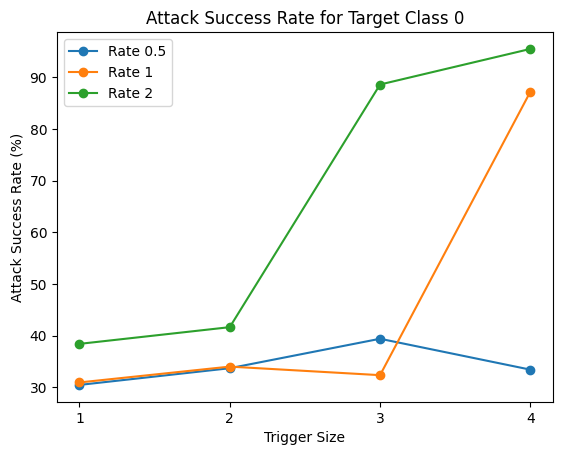

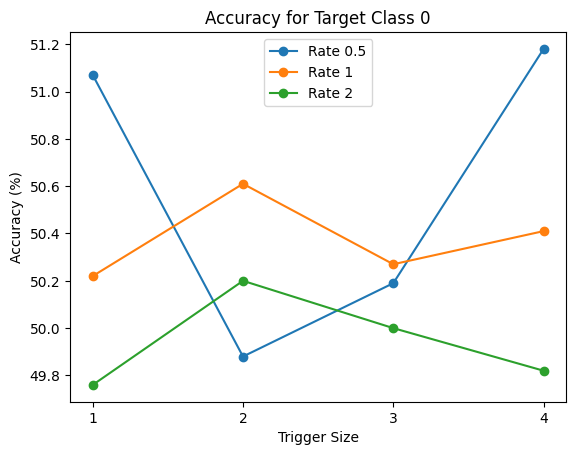

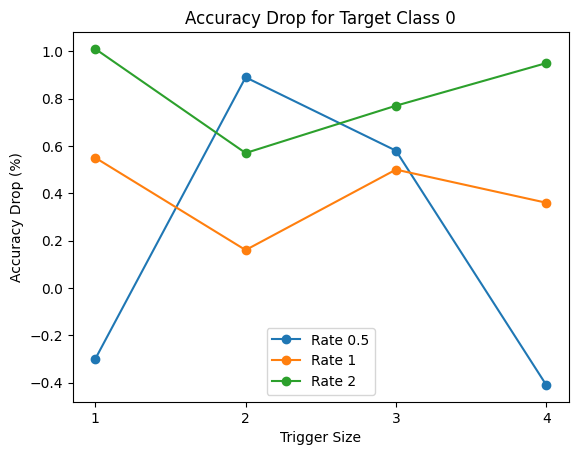

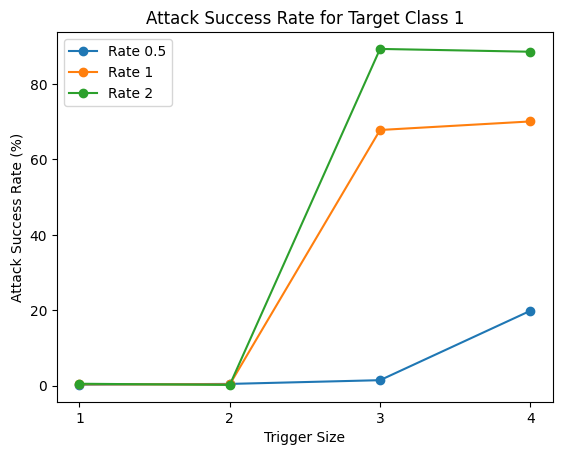

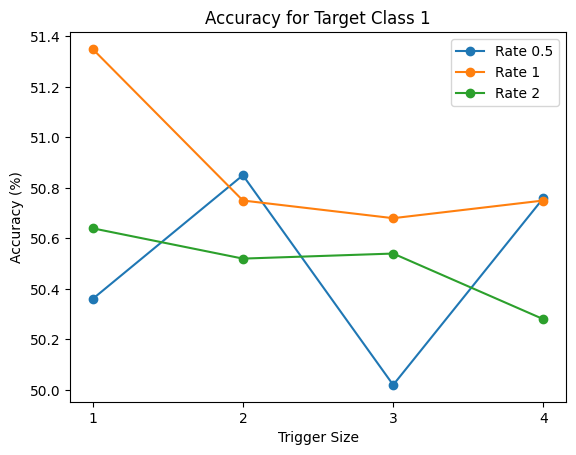

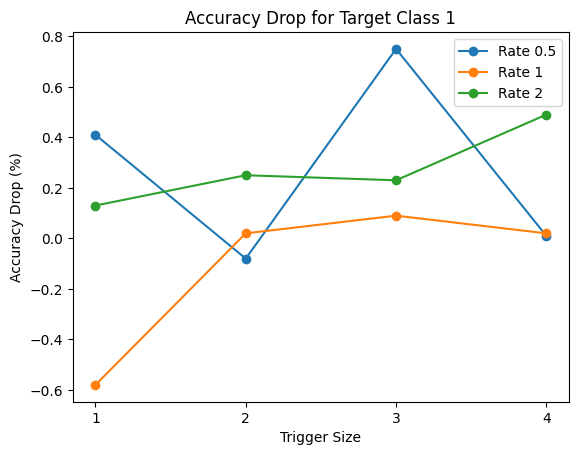

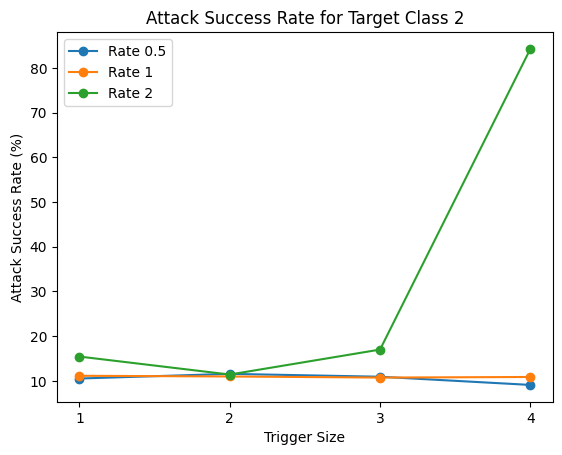

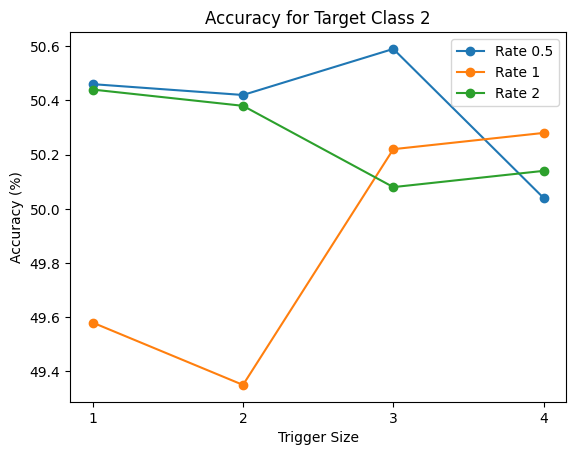

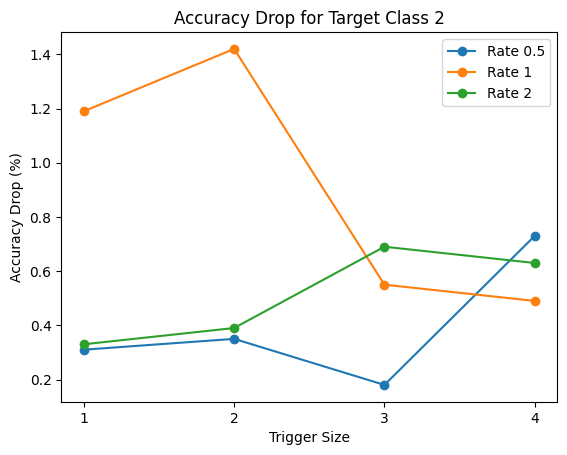

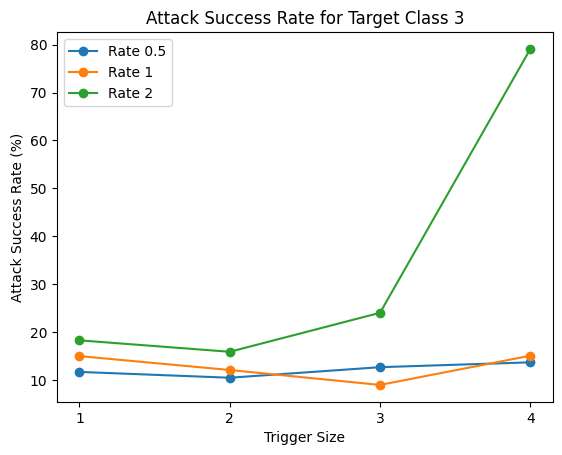

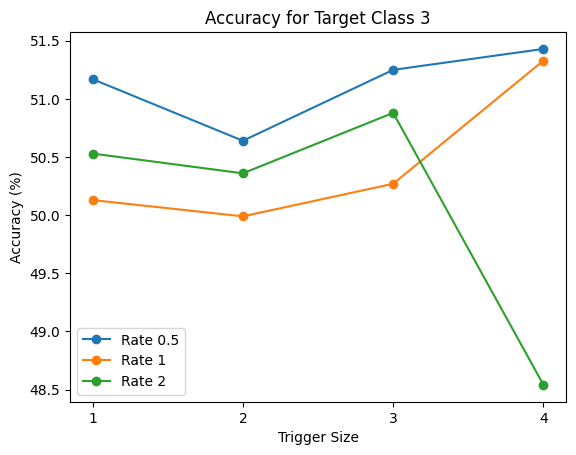

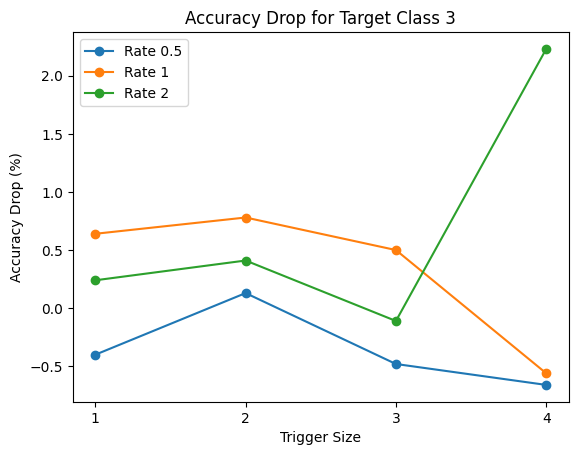

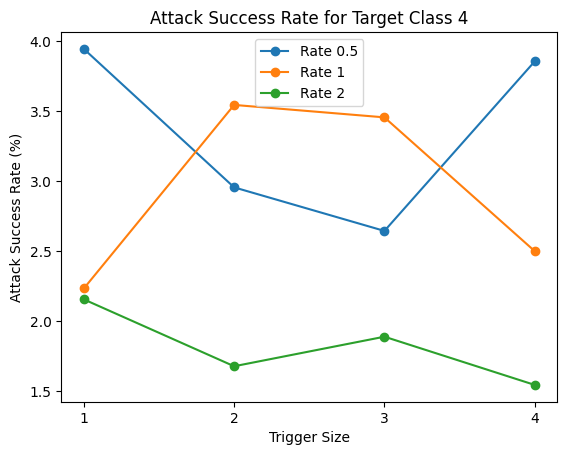

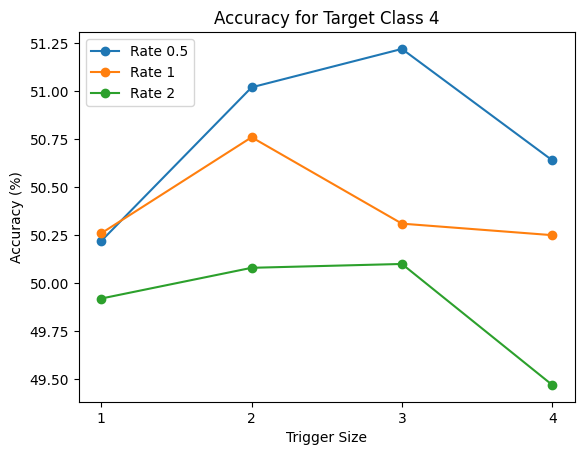

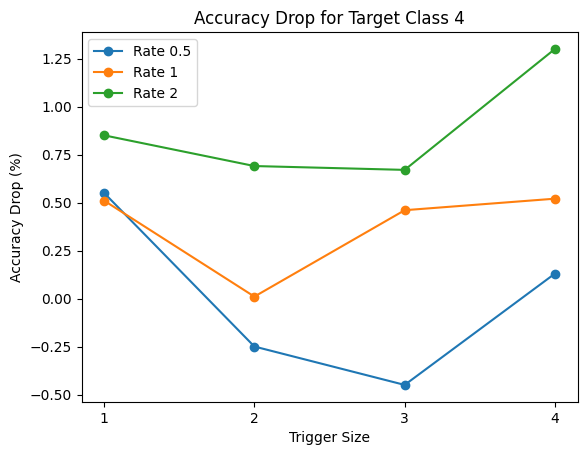

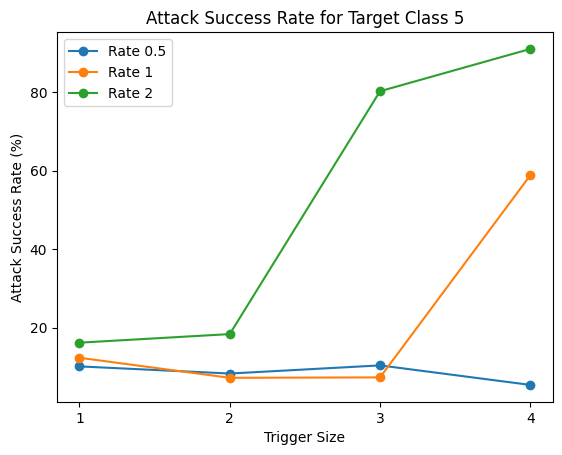

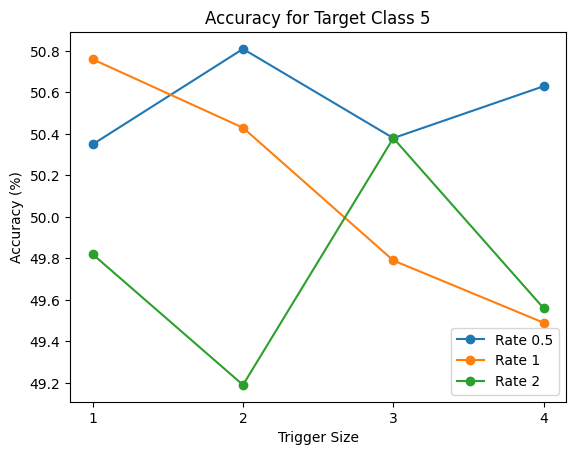

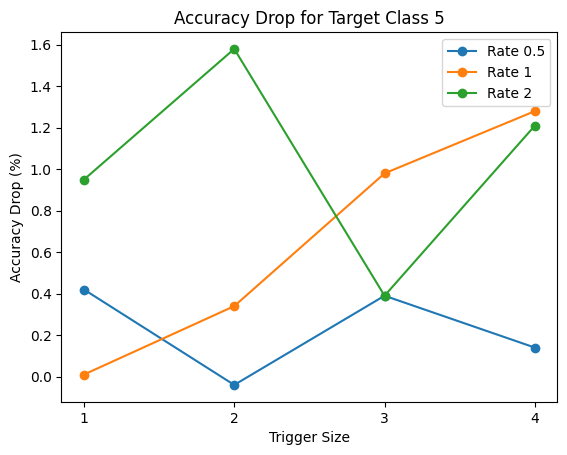

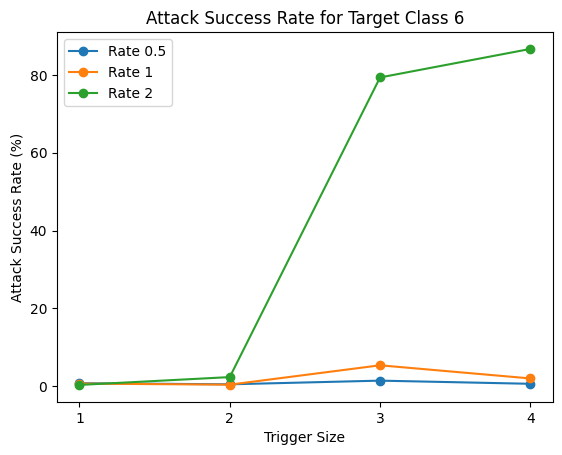

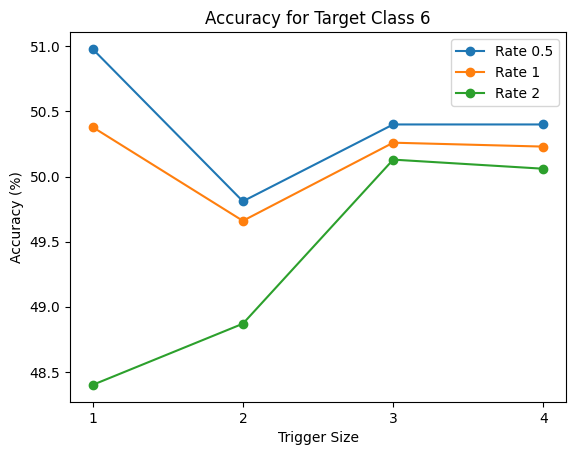

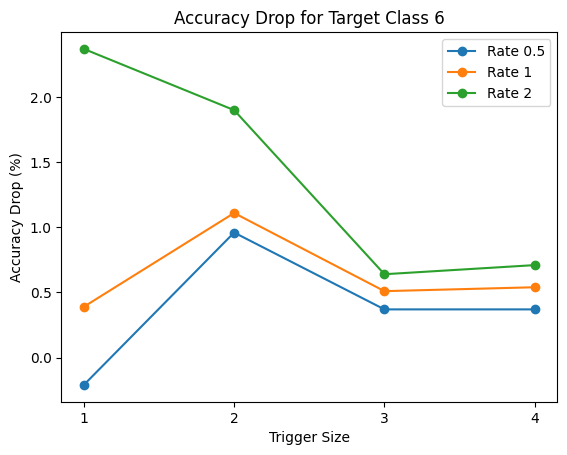

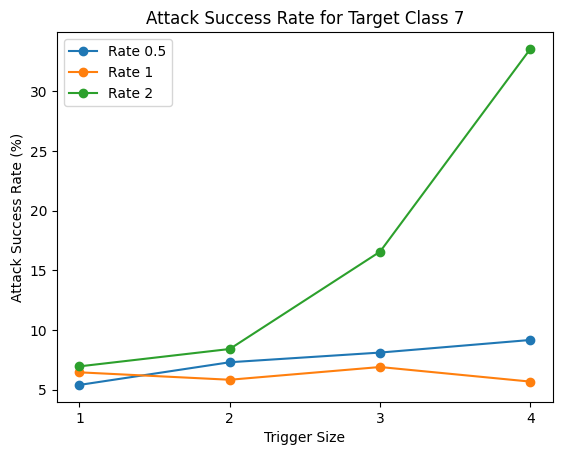

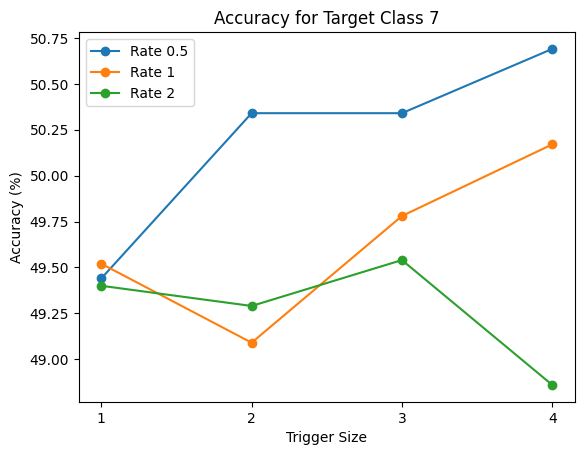

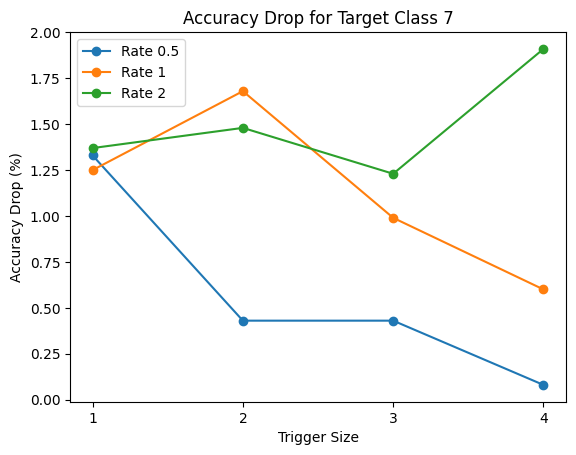

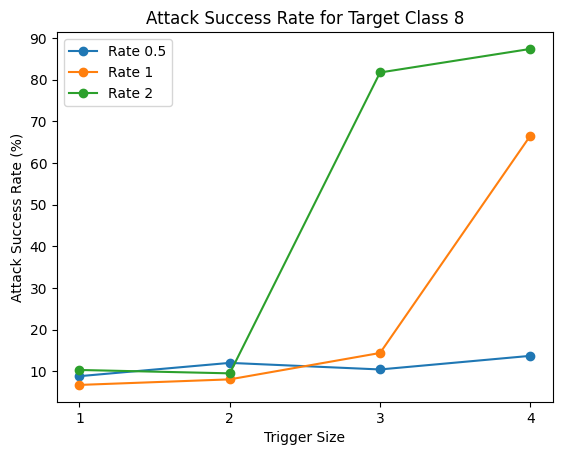

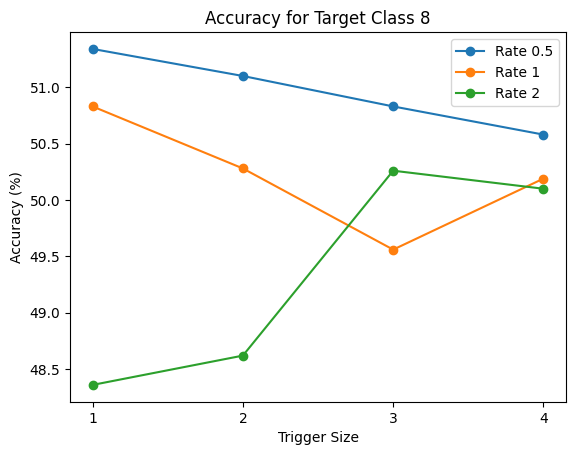

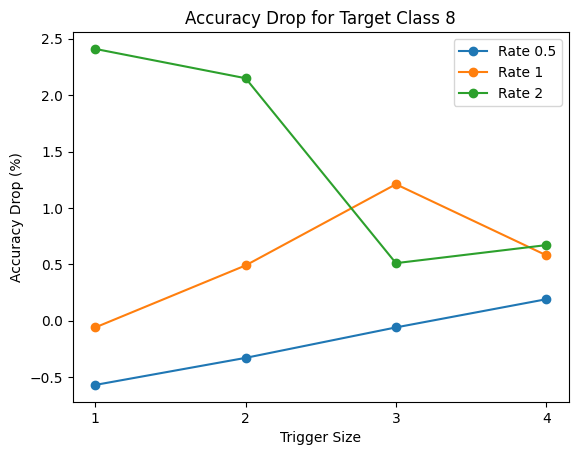

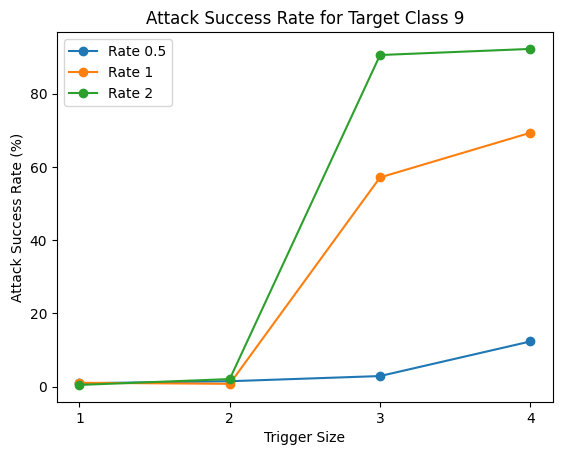

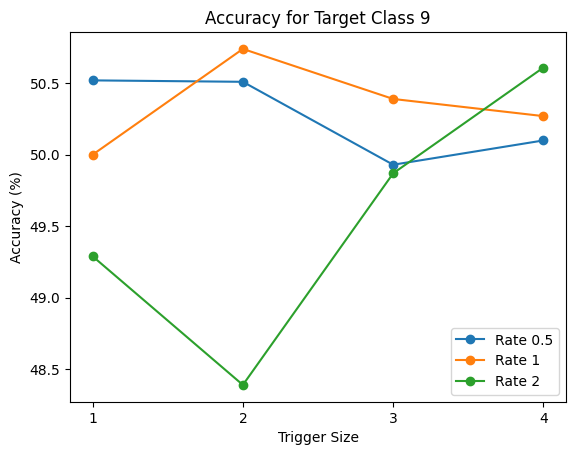

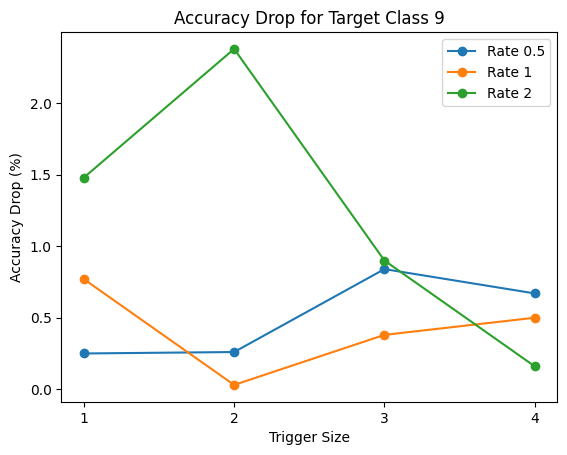

In [ ]:
for i in range(10):
  for j in ['asr', "acc", "acc_drop"]:
    plot_metric(results_cifar_dirty, i, j)

### Performing Grid Search with Autoencoder Transformed Data $-$ CIFAR10 $-$ 128D

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True, train=False)
testset_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified


In [ ]:
poison_rates = [0.5, 1, 2]
trigger_sizes = [1, 2, 3, 4]
accuracies, asrs = [], []
results_cifar_dirty_128D = defaultdict(dict)

for target in range(10):
    for rate in poison_rates:
        for size in trigger_sizes:
            desc = f'rate={rate}, target_class={target}, trigger_size={size}'
            print("[Description] {}".format(desc))

            poisoned_trainset, _ = poison_dirty(rate, size, target, dataset_to_use='CIFAR10')
            poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size, shuffle=True, pin_memory=True)

            poisoned_testset = poison_testset(size, 'CIFAR10')
            poisoned_testloader = torch.utils.data.DataLoader(poisoned_testset, batch_size, shuffle=False, pin_memory=True)

            set_seed()

            # Models
            autoencoder = Autoencoder_CIFAR10(base_channel_size=32, latent_dim=128).to(device)
            classifier = Classifier_CIFAR10().to(device)

            # Loss function
            autoencoder_criterion = nn.MSELoss()
            classifier_criterion = nn.CrossEntropyLoss()

            # Optimizers
            autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
            classifier_optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

            train(autoencoder, classifier, poisoned_trainloader,
                  autoencoder_optimizer, classifier_optimizer,
                  autoencoder_criterion, classifier_criterion, num_epochs=5)

            results_cifar_dirty_128D[desc]['acc'] = test(autoencoder, classifier, testset_loader)
            results_cifar_dirty_128D[desc]['asr'] = calculate_ASR(autoencoder, classifier, poisoned_testloader, target)
            results_cifar_dirty_128D[desc]['acc_drop'] = acc_clean_cifar_128D - results_cifar_dirty_128D[desc]['acc']

            print("--------------------")


[Description] rate=0.5, target_class=0, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.99s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.85it/s]



[Plain/Test] Accuracy: 67.370
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.57it/s]



[Poisoned/Test] Attack success rate: 25.956

--------------------
[Description] rate=0.5, target_class=0, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:11<00:00, 26.24s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.93it/s]



[Plain/Test] Accuracy: 68.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.14it/s]



[Poisoned/Test] Attack success rate: 14.644

--------------------
[Description] rate=0.5, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.47s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.93it/s]



[Plain/Test] Accuracy: 68.180
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 56.10it/s]



[Poisoned/Test] Attack success rate: 17.000

--------------------
[Description] rate=0.5, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.52s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.75it/s]



[Plain/Test] Accuracy: 68.020
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.63it/s]



[Poisoned/Test] Attack success rate: 75.878

--------------------
[Description] rate=1, target_class=0, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.62s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.36it/s]



[Plain/Test] Accuracy: 68.160
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.28it/s]



[Poisoned/Test] Attack success rate: 20.233

--------------------
[Description] rate=1, target_class=0, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.42s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.75it/s]



[Plain/Test] Accuracy: 67.620
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.41it/s]



[Poisoned/Test] Attack success rate: 16.778

--------------------
[Description] rate=1, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.49s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.31it/s]



[Plain/Test] Accuracy: 68.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.27it/s]



[Poisoned/Test] Attack success rate: 69.222

--------------------
[Description] rate=1, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.44s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.79it/s]



[Plain/Test] Accuracy: 67.680
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.62it/s]



[Poisoned/Test] Attack success rate: 90.522

--------------------
[Description] rate=2, target_class=0, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.65s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.90it/s]



[Plain/Test] Accuracy: 67.930
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.12it/s]



[Poisoned/Test] Attack success rate: 14.756

--------------------
[Description] rate=2, target_class=0, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.18it/s]



[Plain/Test] Accuracy: 67.860
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.03it/s]



[Poisoned/Test] Attack success rate: 83.056

--------------------
[Description] rate=2, target_class=0, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.82it/s]



[Plain/Test] Accuracy: 68.080
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.60it/s]



[Poisoned/Test] Attack success rate: 91.600

--------------------
[Description] rate=2, target_class=0, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.29it/s]



[Plain/Test] Accuracy: 68.510
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.56it/s]



[Poisoned/Test] Attack success rate: 95.111

--------------------
[Description] rate=0.5, target_class=1, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.41it/s]



[Plain/Test] Accuracy: 68.560
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.81it/s]



[Poisoned/Test] Attack success rate: 0.078

--------------------
[Description] rate=0.5, target_class=1, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.51s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.24it/s]



[Plain/Test] Accuracy: 68.800
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.43it/s]



[Poisoned/Test] Attack success rate: 0.033

--------------------
[Description] rate=0.5, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.62s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.37it/s]



[Plain/Test] Accuracy: 68.190
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 56.12it/s]



[Poisoned/Test] Attack success rate: 11.600

--------------------
[Description] rate=0.5, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.57s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.55it/s]



[Plain/Test] Accuracy: 68.070
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.73it/s]



[Poisoned/Test] Attack success rate: 38.789

--------------------
[Description] rate=1, target_class=1, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.72s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 36.54it/s]



[Plain/Test] Accuracy: 68.260
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.97it/s]



[Poisoned/Test] Attack success rate: 0.044

--------------------
[Description] rate=1, target_class=1, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.96it/s]



[Plain/Test] Accuracy: 68.910
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.73it/s]



[Poisoned/Test] Attack success rate: 0.022

--------------------
[Description] rate=1, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.59s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.98it/s]



[Plain/Test] Accuracy: 67.820
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.91it/s]



[Poisoned/Test] Attack success rate: 68.211

--------------------
[Description] rate=1, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.70s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.23it/s]



[Plain/Test] Accuracy: 68.870
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.28it/s]



[Poisoned/Test] Attack success rate: 87.211

--------------------
[Description] rate=2, target_class=1, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.50s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.24it/s]



[Plain/Test] Accuracy: 67.890
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.81it/s]



[Poisoned/Test] Attack success rate: 0.044

--------------------
[Description] rate=2, target_class=1, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.68s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.98it/s]



[Plain/Test] Accuracy: 68.710
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.02it/s]



[Poisoned/Test] Attack success rate: 70.711

--------------------
[Description] rate=2, target_class=1, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.20it/s]



[Plain/Test] Accuracy: 67.920
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.21it/s]



[Poisoned/Test] Attack success rate: 90.200

--------------------
[Description] rate=2, target_class=1, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.43s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 31.86it/s]



[Plain/Test] Accuracy: 67.390
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.00it/s]



[Poisoned/Test] Attack success rate: 92.700

--------------------
[Description] rate=0.5, target_class=2, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:01<00:00, 24.39s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 39.13it/s]



[Plain/Test] Accuracy: 68.590
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.76it/s]



[Poisoned/Test] Attack success rate: 12.922

--------------------
[Description] rate=0.5, target_class=2, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.59s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.60it/s]



[Plain/Test] Accuracy: 67.880
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 56.59it/s]



[Poisoned/Test] Attack success rate: 7.244

--------------------
[Description] rate=0.5, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.71s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.26it/s]



[Plain/Test] Accuracy: 67.850
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.44it/s]



[Poisoned/Test] Attack success rate: 9.667

--------------------
[Description] rate=0.5, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.56s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.64it/s]



[Plain/Test] Accuracy: 67.960
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.48it/s]



[Poisoned/Test] Attack success rate: 56.756

--------------------
[Description] rate=1, target_class=2, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.60s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.82it/s]



[Plain/Test] Accuracy: 68.060
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.14it/s]



[Poisoned/Test] Attack success rate: 9.722

--------------------
[Description] rate=1, target_class=2, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.62s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.22it/s]



[Plain/Test] Accuracy: 67.990
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.18it/s]



[Poisoned/Test] Attack success rate: 8.833

--------------------
[Description] rate=1, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:01<00:00, 24.35s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.33it/s]



[Plain/Test] Accuracy: 68.080
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.35it/s]



[Poisoned/Test] Attack success rate: 77.489

--------------------
[Description] rate=1, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.61it/s]



[Plain/Test] Accuracy: 68.050
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.86it/s]



[Poisoned/Test] Attack success rate: 89.789

--------------------
[Description] rate=2, target_class=2, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.59s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.59it/s]



[Plain/Test] Accuracy: 67.420
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.06it/s]



[Poisoned/Test] Attack success rate: 4.067

--------------------
[Description] rate=2, target_class=2, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.70s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.78it/s]



[Plain/Test] Accuracy: 68.030
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.28it/s]



[Poisoned/Test] Attack success rate: 75.878

--------------------
[Description] rate=2, target_class=2, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.42s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.91it/s]



[Plain/Test] Accuracy: 68.210
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.24it/s]



[Poisoned/Test] Attack success rate: 91.144

--------------------
[Description] rate=2, target_class=2, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.57s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.18it/s]



[Plain/Test] Accuracy: 68.170
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.35it/s]



[Poisoned/Test] Attack success rate: 92.900

--------------------
[Description] rate=0.5, target_class=3, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.54s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.35it/s]



[Plain/Test] Accuracy: 67.990
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.89it/s]



[Poisoned/Test] Attack success rate: 20.400

--------------------
[Description] rate=0.5, target_class=3, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.60s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.61it/s]



[Plain/Test] Accuracy: 68.470
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.38it/s]



[Poisoned/Test] Attack success rate: 21.744

--------------------
[Description] rate=0.5, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.74s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.96it/s]



[Plain/Test] Accuracy: 68.730
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.49it/s]



[Poisoned/Test] Attack success rate: 63.367

--------------------
[Description] rate=0.5, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.63s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.60it/s]



[Plain/Test] Accuracy: 69.020
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.99it/s]



[Poisoned/Test] Attack success rate: 82.533

--------------------
[Description] rate=1, target_class=3, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.31it/s]



[Plain/Test] Accuracy: 68.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.13it/s]



[Poisoned/Test] Attack success rate: 22.556

--------------------
[Description] rate=1, target_class=3, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.65s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.41it/s]



[Plain/Test] Accuracy: 68.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.47it/s]



[Poisoned/Test] Attack success rate: 23.656

--------------------
[Description] rate=1, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.45s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.58it/s]



[Plain/Test] Accuracy: 68.120
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.45it/s]



[Poisoned/Test] Attack success rate: 81.644

--------------------
[Description] rate=1, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.45s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.03it/s]



[Plain/Test] Accuracy: 68.010
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.80it/s]



[Poisoned/Test] Attack success rate: 91.333

--------------------
[Description] rate=2, target_class=3, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.58s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.95it/s]



[Plain/Test] Accuracy: 68.640
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.38it/s]



[Poisoned/Test] Attack success rate: 19.789

--------------------
[Description] rate=2, target_class=3, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.53s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 35.52it/s]



[Plain/Test] Accuracy: 67.940
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.23it/s]



[Poisoned/Test] Attack success rate: 38.611

--------------------
[Description] rate=2, target_class=3, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.61s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.25it/s]



[Plain/Test] Accuracy: 67.450
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.83it/s]



[Poisoned/Test] Attack success rate: 93.056

--------------------
[Description] rate=2, target_class=3, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.49s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 32.11it/s]



[Plain/Test] Accuracy: 68.330
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.13it/s]



[Poisoned/Test] Attack success rate: 97.056

--------------------
[Description] rate=0.5, target_class=4, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.46s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.94it/s]



[Plain/Test] Accuracy: 67.830
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.46it/s]



[Poisoned/Test] Attack success rate: 3.322

--------------------
[Description] rate=0.5, target_class=4, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.55s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.66it/s]



[Plain/Test] Accuracy: 67.490
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.43it/s]



[Poisoned/Test] Attack success rate: 2.456

--------------------
[Description] rate=0.5, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.53s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.82it/s]



[Plain/Test] Accuracy: 67.800
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.20it/s]



[Poisoned/Test] Attack success rate: 3.833

--------------------
[Description] rate=0.5, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.62s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.54it/s]



[Plain/Test] Accuracy: 67.720
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.56it/s]



[Poisoned/Test] Attack success rate: 59.778

--------------------
[Description] rate=1, target_class=4, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.49it/s]



[Plain/Test] Accuracy: 67.970
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.66it/s]



[Poisoned/Test] Attack success rate: 2.933

--------------------
[Description] rate=1, target_class=4, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.49s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.27it/s]



[Plain/Test] Accuracy: 67.870
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.57it/s]



[Poisoned/Test] Attack success rate: 3.744

--------------------
[Description] rate=1, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.14it/s]



[Plain/Test] Accuracy: 67.840
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 48.71it/s]



[Poisoned/Test] Attack success rate: 47.022

--------------------
[Description] rate=1, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.55s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.10it/s]



[Plain/Test] Accuracy: 68.070
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.53it/s]



[Poisoned/Test] Attack success rate: 85.967

--------------------
[Description] rate=2, target_class=4, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.55s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.21it/s]



[Plain/Test] Accuracy: 67.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.02it/s]



[Poisoned/Test] Attack success rate: 4.622

--------------------
[Description] rate=2, target_class=4, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:01<00:00, 24.37s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.26it/s]



[Plain/Test] Accuracy: 66.680
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.67it/s]



[Poisoned/Test] Attack success rate: 28.056

--------------------
[Description] rate=2, target_class=4, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.55s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.26it/s]



[Plain/Test] Accuracy: 67.410
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.39it/s]



[Poisoned/Test] Attack success rate: 90.644

--------------------
[Description] rate=2, target_class=4, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.62s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.09it/s]



[Plain/Test] Accuracy: 67.720
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.03it/s]



[Poisoned/Test] Attack success rate: 90.922

--------------------
[Description] rate=0.5, target_class=5, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.52s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.99it/s]



[Plain/Test] Accuracy: 67.770
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.72it/s]



[Poisoned/Test] Attack success rate: 3.544

--------------------
[Description] rate=0.5, target_class=5, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.45s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.42it/s]



[Plain/Test] Accuracy: 68.030
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 51.04it/s]



[Poisoned/Test] Attack success rate: 4.333

--------------------
[Description] rate=0.5, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.45s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.32it/s]



[Plain/Test] Accuracy: 67.990
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.88it/s]



[Poisoned/Test] Attack success rate: 7.933

--------------------
[Description] rate=0.5, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:01<00:00, 24.40s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 32.95it/s]



[Plain/Test] Accuracy: 68.200
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.54it/s]



[Poisoned/Test] Attack success rate: 72.644

--------------------
[Description] rate=1, target_class=5, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.43s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 39.15it/s]



[Plain/Test] Accuracy: 67.290
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.38it/s]



[Poisoned/Test] Attack success rate: 4.589

--------------------
[Description] rate=1, target_class=5, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.51s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.75it/s]



[Plain/Test] Accuracy: 67.480
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.04it/s]



[Poisoned/Test] Attack success rate: 7.189

--------------------
[Description] rate=1, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.47s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.13it/s]



[Plain/Test] Accuracy: 67.600
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.57it/s]



[Poisoned/Test] Attack success rate: 80.622

--------------------
[Description] rate=1, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.51s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 36.76it/s]



[Plain/Test] Accuracy: 67.350
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.06it/s]



[Poisoned/Test] Attack success rate: 91.056

--------------------
[Description] rate=2, target_class=5, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:01<00:00, 24.39s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.66it/s]



[Plain/Test] Accuracy: 67.480
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.85it/s]



[Poisoned/Test] Attack success rate: 9.622

--------------------
[Description] rate=2, target_class=5, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.40s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.83it/s]



[Plain/Test] Accuracy: 67.080
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.90it/s]



[Poisoned/Test] Attack success rate: 19.078

--------------------
[Description] rate=2, target_class=5, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.54s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 35.03it/s]



[Plain/Test] Accuracy: 67.960
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.69it/s]



[Poisoned/Test] Attack success rate: 92.644

--------------------
[Description] rate=2, target_class=5, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.60s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.54it/s]



[Plain/Test] Accuracy: 67.250
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.31it/s]



[Poisoned/Test] Attack success rate: 95.967

--------------------
[Description] rate=0.5, target_class=6, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.64s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 36.85it/s]



[Plain/Test] Accuracy: 68.290
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.63it/s]



[Poisoned/Test] Attack success rate: 0.244

--------------------
[Description] rate=0.5, target_class=6, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.60it/s]



[Plain/Test] Accuracy: 68.500
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.34it/s]



[Poisoned/Test] Attack success rate: 0.089

--------------------
[Description] rate=0.5, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.73s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.19it/s]



[Plain/Test] Accuracy: 68.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.28it/s]



[Poisoned/Test] Attack success rate: 1.544

--------------------
[Description] rate=0.5, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.73s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 33.66it/s]



[Plain/Test] Accuracy: 67.930
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.44it/s]



[Poisoned/Test] Attack success rate: 77.633

--------------------
[Description] rate=1, target_class=6, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.63s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.47it/s]



[Plain/Test] Accuracy: 68.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.22it/s]



[Poisoned/Test] Attack success rate: 0.500

--------------------
[Description] rate=1, target_class=6, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.59s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 36.43it/s]



[Plain/Test] Accuracy: 68.550
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.02it/s]



[Poisoned/Test] Attack success rate: 0.156

--------------------
[Description] rate=1, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.61s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.32it/s]



[Plain/Test] Accuracy: 68.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.77it/s]



[Poisoned/Test] Attack success rate: 78.822

--------------------
[Description] rate=1, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.44it/s]



[Plain/Test] Accuracy: 68.380
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.30it/s]



[Poisoned/Test] Attack success rate: 86.278

--------------------
[Description] rate=2, target_class=6, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 32.89it/s]



[Plain/Test] Accuracy: 67.080
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.37it/s]



[Poisoned/Test] Attack success rate: 0.478

--------------------
[Description] rate=2, target_class=6, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.32it/s]



[Plain/Test] Accuracy: 67.670
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.72it/s]



[Poisoned/Test] Attack success rate: 59.800

--------------------
[Description] rate=2, target_class=6, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.75s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 35.95it/s]



[Plain/Test] Accuracy: 67.010
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.34it/s]



[Poisoned/Test] Attack success rate: 92.678

--------------------
[Description] rate=2, target_class=6, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.67s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.97it/s]



[Plain/Test] Accuracy: 67.630
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.46it/s]



[Poisoned/Test] Attack success rate: 95.233

--------------------
[Description] rate=0.5, target_class=7, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:02<00:00, 24.51s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.75it/s]



[Plain/Test] Accuracy: 67.600
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.41it/s]



[Poisoned/Test] Attack success rate: 0.333

--------------------
[Description] rate=0.5, target_class=7, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.28it/s]



[Plain/Test] Accuracy: 68.790
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.91it/s]



[Poisoned/Test] Attack success rate: 0.456

--------------------
[Description] rate=0.5, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.26it/s]



[Plain/Test] Accuracy: 68.140
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 41.65it/s]



[Poisoned/Test] Attack success rate: 1.122

--------------------
[Description] rate=0.5, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:06<00:00, 25.21s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.03it/s]



[Plain/Test] Accuracy: 68.240
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.80it/s]



[Poisoned/Test] Attack success rate: 44.222

--------------------
[Description] rate=1, target_class=7, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 35.04it/s]



[Plain/Test] Accuracy: 67.830
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 49.75it/s]



[Poisoned/Test] Attack success rate: 0.667

--------------------
[Description] rate=1, target_class=7, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.34it/s]



[Plain/Test] Accuracy: 67.780
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.90it/s]



[Poisoned/Test] Attack success rate: 0.278

--------------------
[Description] rate=1, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 36.31it/s]



[Plain/Test] Accuracy: 68.170
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.15it/s]



[Poisoned/Test] Attack success rate: 60.811

--------------------
[Description] rate=1, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.76s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.92it/s]



[Plain/Test] Accuracy: 68.120
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.31it/s]



[Poisoned/Test] Attack success rate: 78.867

--------------------
[Description] rate=2, target_class=7, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.12it/s]



[Plain/Test] Accuracy: 68.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.78it/s]



[Poisoned/Test] Attack success rate: 0.667

--------------------
[Description] rate=2, target_class=7, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.83s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.80it/s]



[Plain/Test] Accuracy: 68.140
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.89it/s]



[Poisoned/Test] Attack success rate: 68.233

--------------------
[Description] rate=2, target_class=7, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.77s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 31.43it/s]



[Plain/Test] Accuracy: 68.650
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.33it/s]



[Poisoned/Test] Attack success rate: 89.833

--------------------
[Description] rate=2, target_class=7, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.61s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.76it/s]



[Plain/Test] Accuracy: 67.870
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.77it/s]



[Poisoned/Test] Attack success rate: 91.067

--------------------
[Description] rate=0.5, target_class=8, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.88s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.41it/s]



[Plain/Test] Accuracy: 67.860
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.78it/s]



[Poisoned/Test] Attack success rate: 18.667

--------------------
[Description] rate=0.5, target_class=8, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.79s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.57it/s]



[Plain/Test] Accuracy: 67.770
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.58it/s]



[Poisoned/Test] Attack success rate: 16.944

--------------------
[Description] rate=0.5, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:05<00:00, 25.05s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.92it/s]



[Plain/Test] Accuracy: 67.610
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.80it/s]



[Poisoned/Test] Attack success rate: 54.556

--------------------
[Description] rate=0.5, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:05<00:00, 25.08s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.74it/s]



[Plain/Test] Accuracy: 67.780
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.39it/s]



[Poisoned/Test] Attack success rate: 86.800

--------------------
[Description] rate=1, target_class=8, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.97s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.53it/s]



[Plain/Test] Accuracy: 67.800
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.65it/s]



[Poisoned/Test] Attack success rate: 13.500

--------------------
[Description] rate=1, target_class=8, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.93s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 36.77it/s]



[Plain/Test] Accuracy: 67.580
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.95it/s]



[Poisoned/Test] Attack success rate: 28.911

--------------------
[Description] rate=1, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.39it/s]



[Plain/Test] Accuracy: 67.290
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 43.89it/s]



[Poisoned/Test] Attack success rate: 90.967

--------------------
[Description] rate=1, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.66s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 34.17it/s]



[Plain/Test] Accuracy: 67.480
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.94it/s]



[Poisoned/Test] Attack success rate: 93.478

--------------------
[Description] rate=2, target_class=8, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.81s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.70it/s]



[Plain/Test] Accuracy: 67.920
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 45.67it/s]



[Poisoned/Test] Attack success rate: 23.533

--------------------
[Description] rate=2, target_class=8, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 32.52it/s]



[Plain/Test] Accuracy: 67.910
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.89it/s]



[Poisoned/Test] Attack success rate: 81.678

--------------------
[Description] rate=2, target_class=8, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.85s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.05it/s]



[Plain/Test] Accuracy: 68.150
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 47.90it/s]



[Poisoned/Test] Attack success rate: 91.933

--------------------
[Description] rate=2, target_class=8, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:05<00:00, 25.02s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 35.52it/s]



[Plain/Test] Accuracy: 67.220
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.34it/s]



[Poisoned/Test] Attack success rate: 94.011

--------------------
[Description] rate=0.5, target_class=9, trigger_size=1
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.86s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.60it/s]



[Plain/Test] Accuracy: 68.340
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.79it/s]



[Poisoned/Test] Attack success rate: 0.122

--------------------
[Description] rate=0.5, target_class=9, trigger_size=2
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.78s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.84it/s]



[Plain/Test] Accuracy: 68.240
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 55.45it/s]



[Poisoned/Test] Attack success rate: 0.144

--------------------
[Description] rate=0.5, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.64s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 38.56it/s]



[Plain/Test] Accuracy: 68.090
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.59it/s]



[Poisoned/Test] Attack success rate: 13.167

--------------------
[Description] rate=0.5, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 250 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:05<00:00, 25.08s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 39.39it/s]



[Plain/Test] Accuracy: 67.690
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.82it/s]



[Poisoned/Test] Attack success rate: 59.056

--------------------
[Description] rate=1, target_class=9, trigger_size=1
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:05<00:00, 25.06s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 37.12it/s]



[Plain/Test] Accuracy: 67.650
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 44.57it/s]



[Poisoned/Test] Attack success rate: 0.167

--------------------
[Description] rate=1, target_class=9, trigger_size=2
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:05<00:00, 25.11s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 39.00it/s]



[Plain/Test] Accuracy: 67.450
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 52.37it/s]



[Poisoned/Test] Attack success rate: 0.311

--------------------
[Description] rate=1, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.82s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 32.72it/s]



[Plain/Test] Accuracy: 68.360
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.50it/s]



[Poisoned/Test] Attack success rate: 74.222

--------------------
[Description] rate=1, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 500 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.96s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 40.38it/s]



[Plain/Test] Accuracy: 67.100
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 54.05it/s]



[Poisoned/Test] Attack success rate: 84.878

--------------------
[Description] rate=2, target_class=9, trigger_size=1
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:04<00:00, 24.90s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:05<00:00, 30.74it/s]



[Plain/Test] Accuracy: 67.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 50.93it/s]



[Poisoned/Test] Attack success rate: 0.211

--------------------
[Description] rate=2, target_class=9, trigger_size=2
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.72s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:05<00:00, 30.90it/s]



[Plain/Test] Accuracy: 68.150
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:02<00:00, 53.63it/s]



[Poisoned/Test] Attack success rate: 0.400

--------------------
[Description] rate=2, target_class=9, trigger_size=3
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.80s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:05<00:00, 28.99it/s]



[Plain/Test] Accuracy: 68.030
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 46.15it/s]



[Poisoned/Test] Attack success rate: 87.989

--------------------
[Description] rate=2, target_class=9, trigger_size=4
[Poisoning/Dirty Label] Poisoning 1000 samples
Files already downloaded and verified
[Poisoning/Testset] Poisoning 10000 samples
[Training] Currently training a model...


100%|██████████| 5/5 [02:03<00:00, 24.69s/it]


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:04<00:00, 35.52it/s]



[Plain/Test] Accuracy: 67.700
[Poisoned/Test] Under Testing ... Please Wait


100%|██████████| 157/157 [00:03<00:00, 42.39it/s]


[Poisoned/Test] Attack success rate: 92.422

--------------------


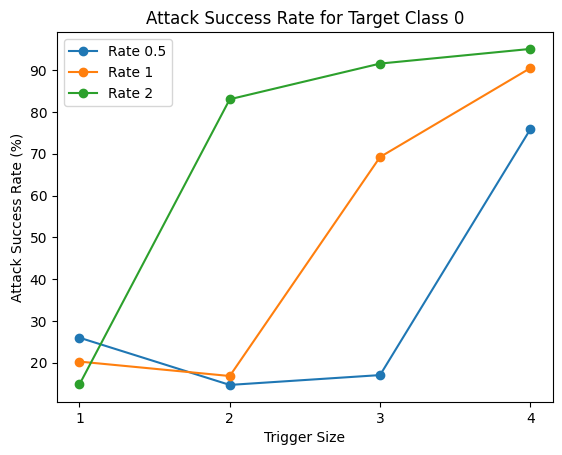

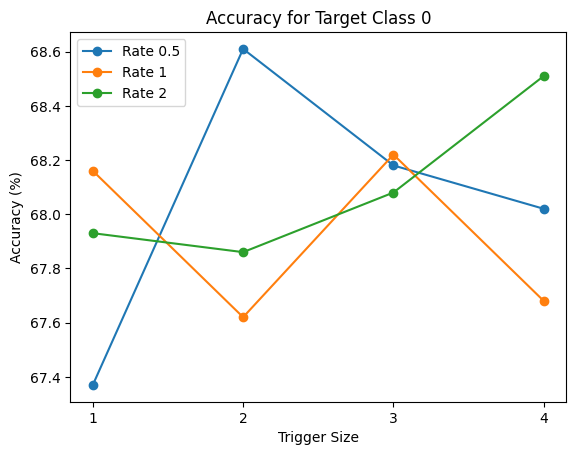

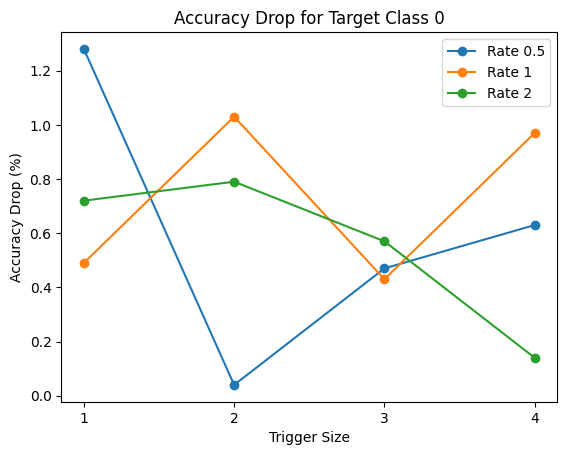

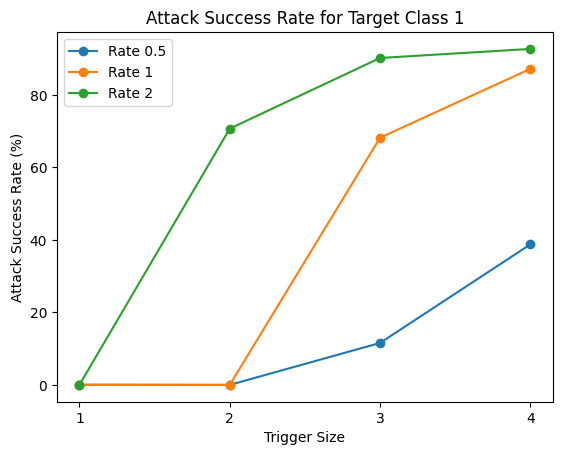

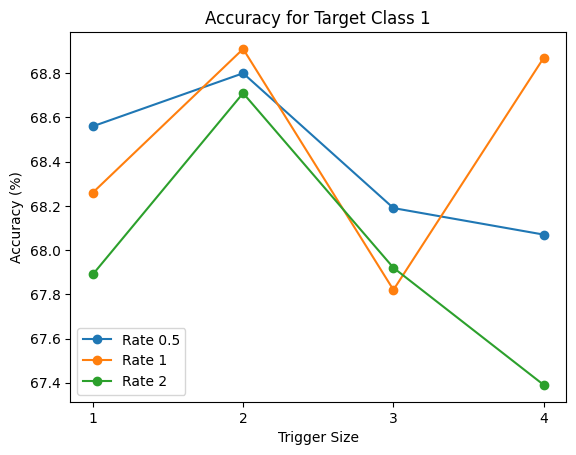

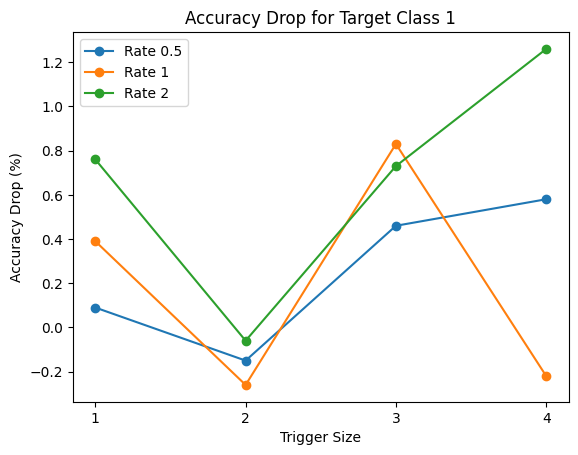

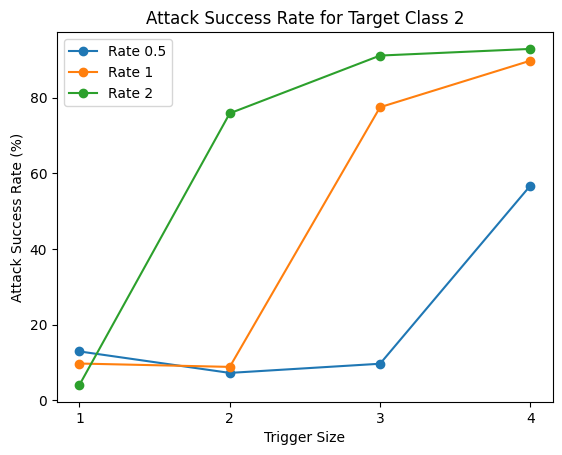

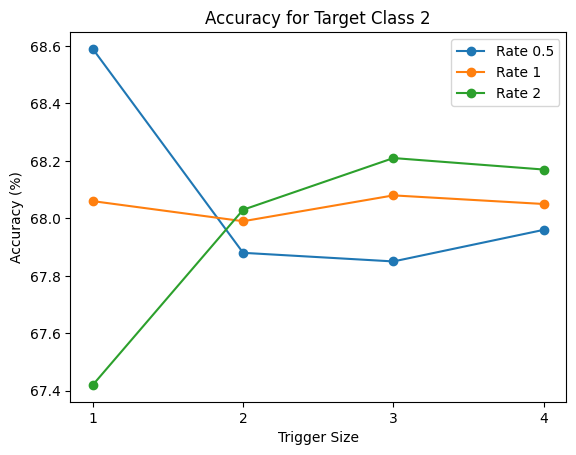

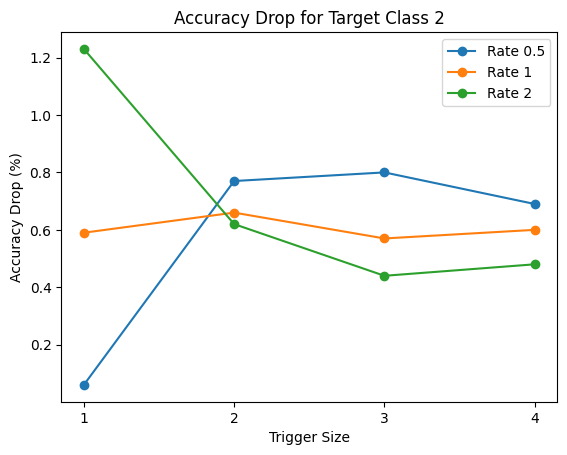

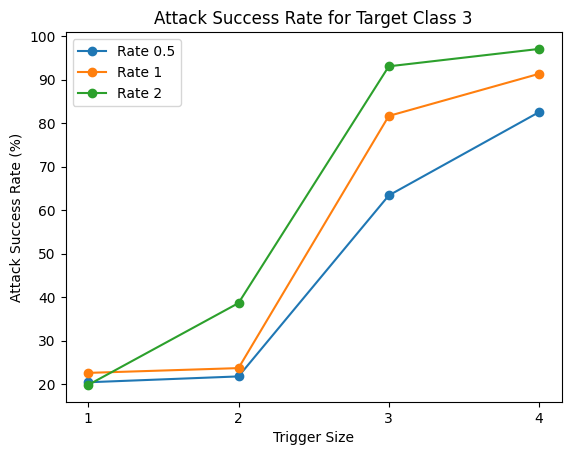

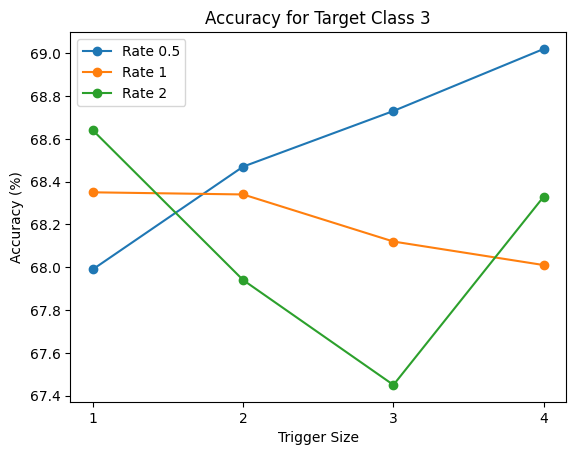

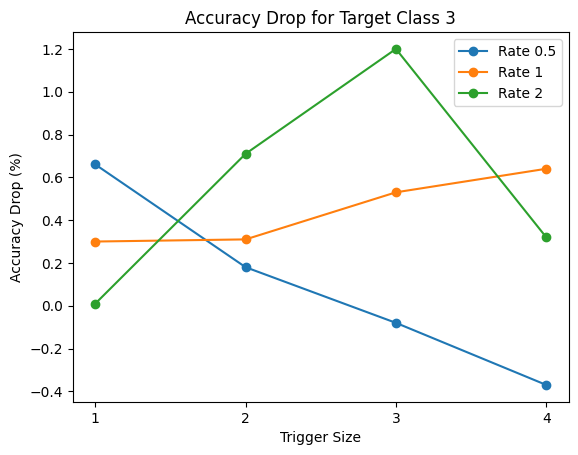

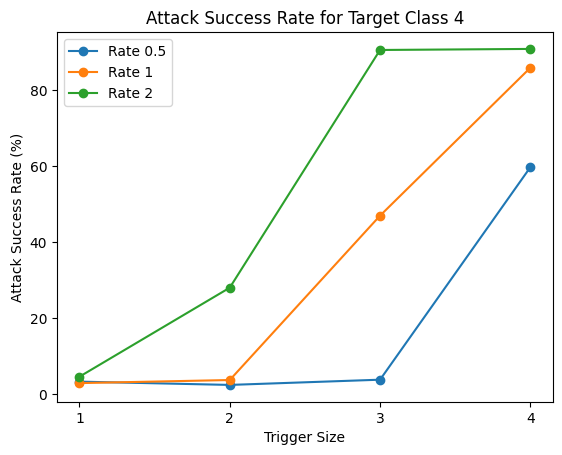

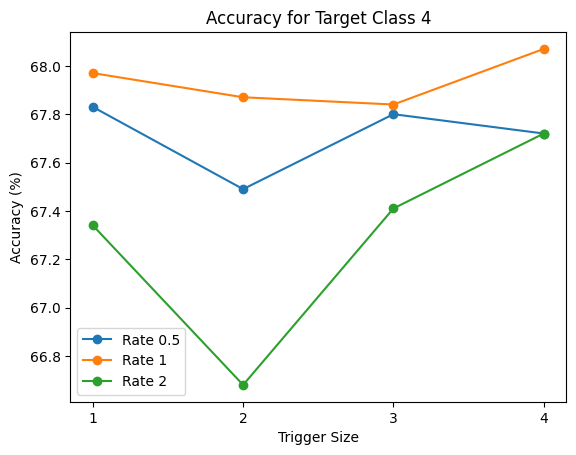

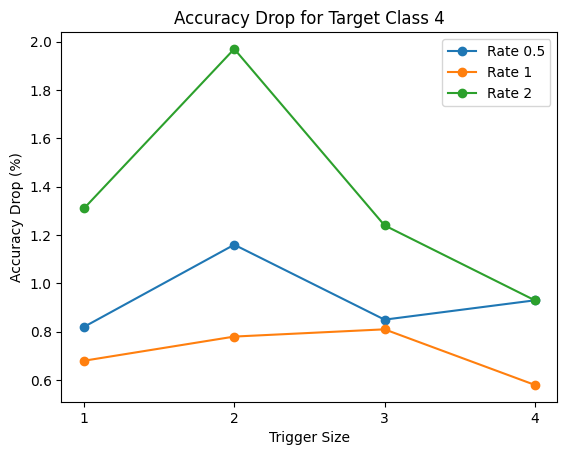

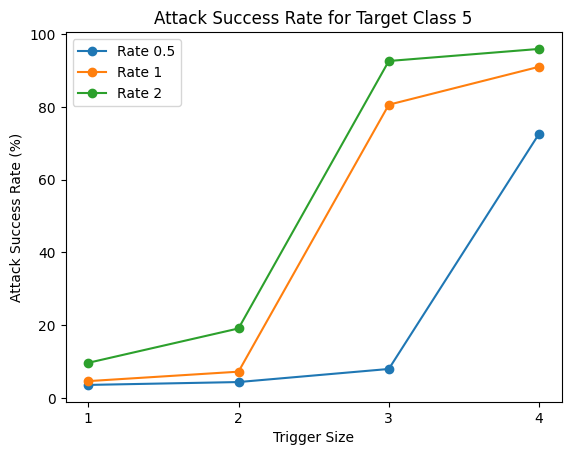

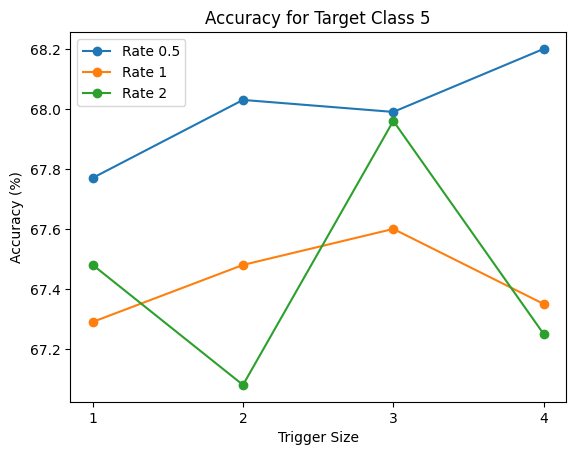

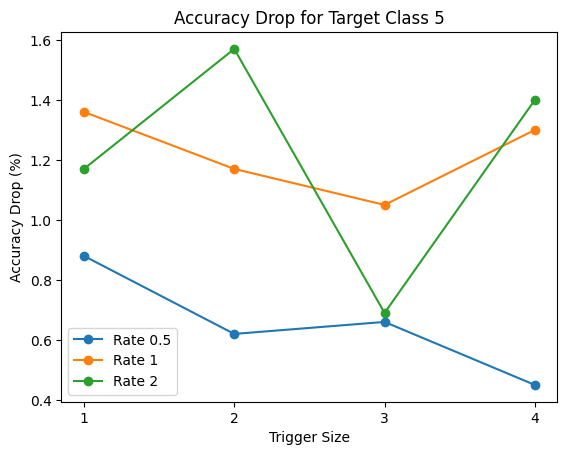

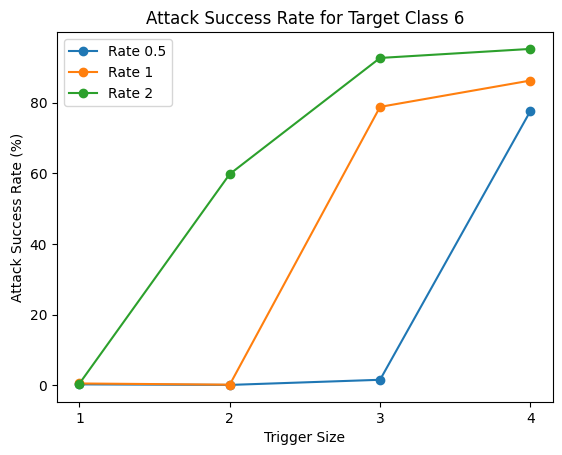

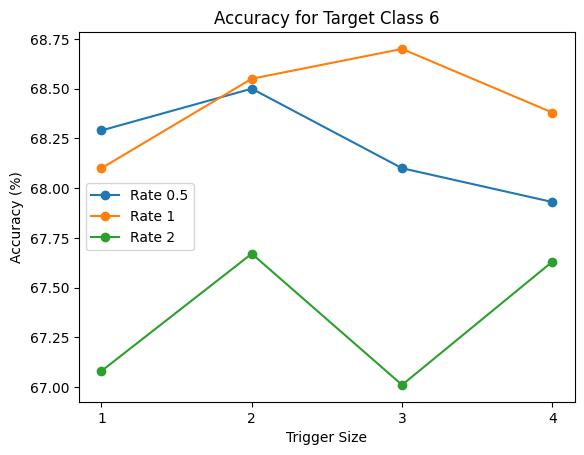

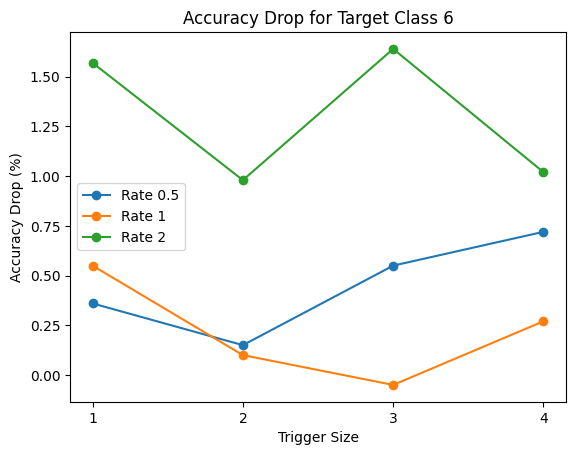

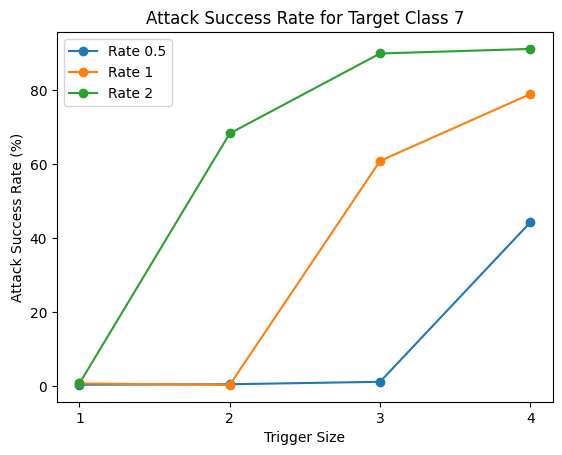

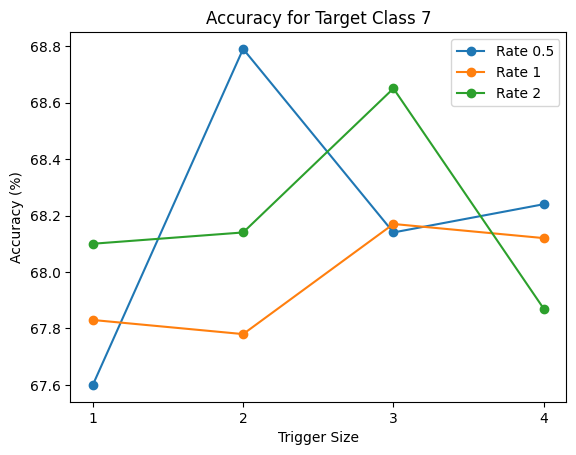

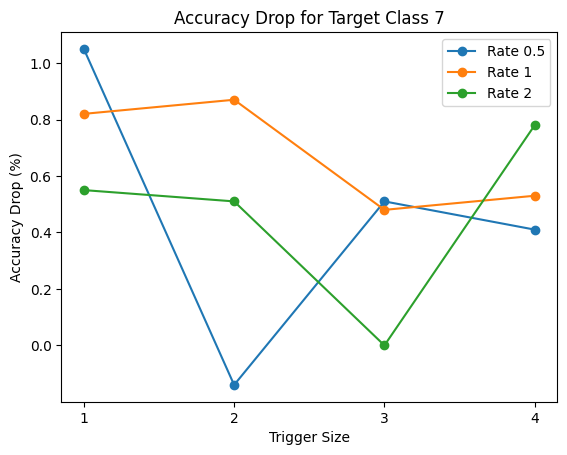

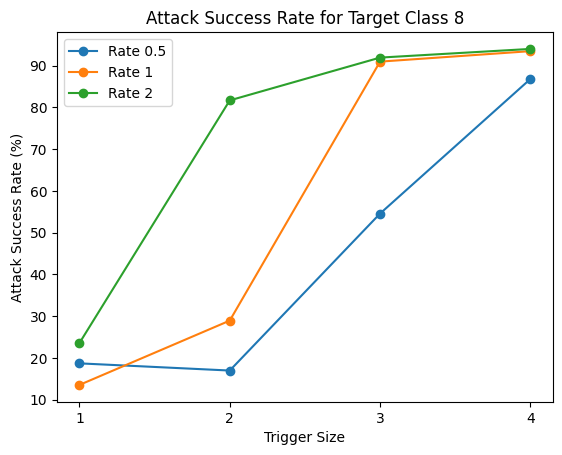

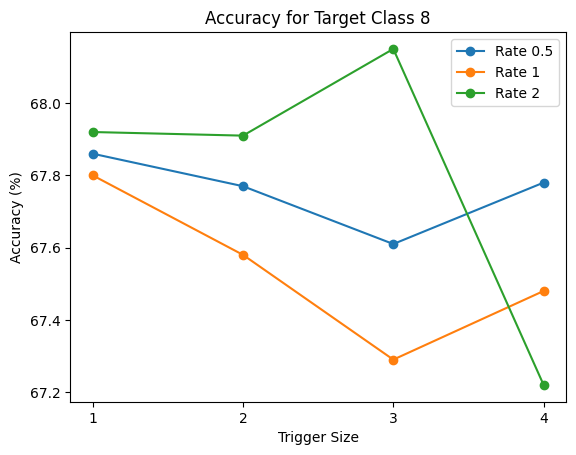

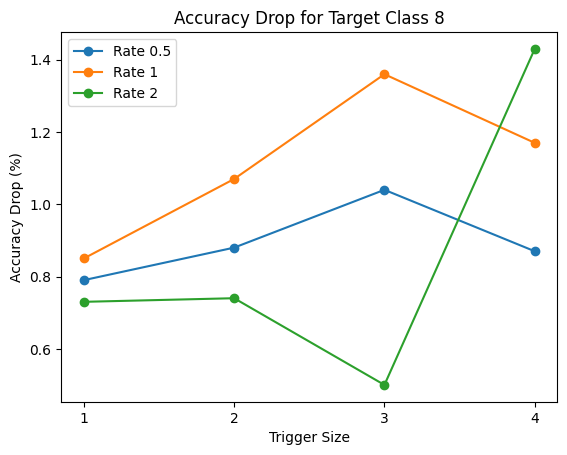

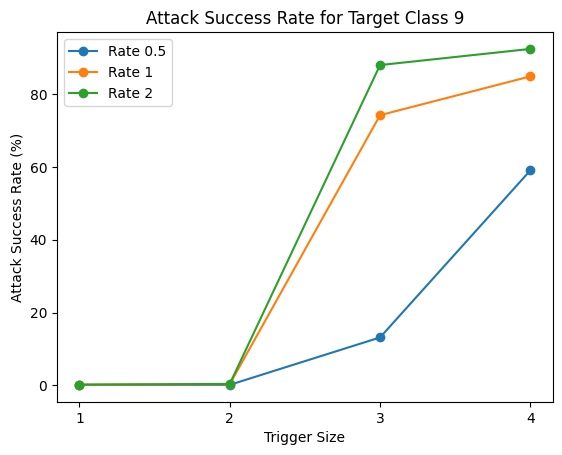

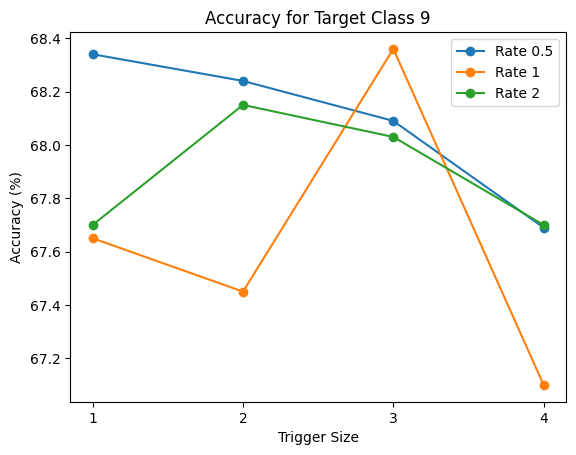

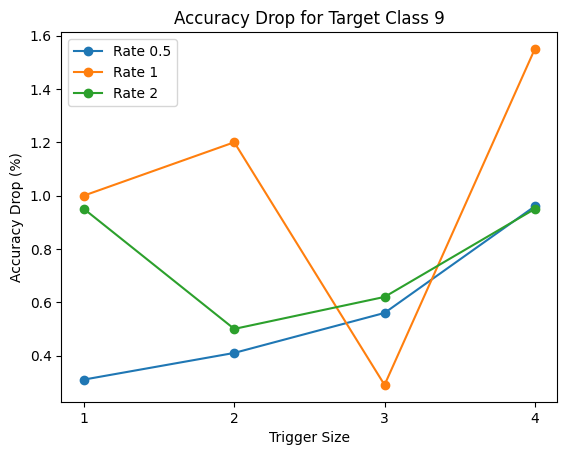

In [ ]:
for i in range(10):
    for j in ['asr', "acc", "acc_drop"]:
        plot_metric(results_cifar_dirty_128D, i, j)